# Importação e Limpeza de Dados

In [ ]:
import yfinance as yf
import pandas as pd

# Lista dos tickers das Magnificent Seven
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA", "META", "TSLA"]

# Loop para coletar os dados de cada ticker e criar um DataFrame específico
for ticker in tickers:
    # Baixa todos os dados históricos (período máximo)
    acao = yf.Ticker(ticker)
    df_completo = acao.history(period="max")

    # Filtra apenas as colunas desejadas
    df = df_completo[["Open", "High", "Low", "Close", "Volume"]]

    # Cria uma variável global com o nome DF_XXXX (onde XXXX é o ticker)
    globals()[f"DF_{ticker}"] = df

    print(f"DF_{ticker} criado com {len(df)} linhas.")


DF_AAPL criado com 11164 linhas.
DF_MSFT criado com 9838 linhas.
DF_AMZN criado com 7012 linhas.
DF_GOOGL criado com 5186 linhas.
DF_NVDA criado com 6587 linhas.
DF_META criado com 3234 linhas.
DF_TSLA criado com 3711 linhas.


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

base_path = '/content/drive/My Drive/TCC/Dados/Corrected_HD'

# --- 1) Função Auxiliar para “Explodir” as datas do HD ---
def explode_and_ffill(df_hd, date_col='Corrected_Date'):
    """
    Recebe o DataFrame HD, assume que df_hd[date_col] seja a coluna de datas.
    Cria um range diário entre min e max dessas datas, coloca df_hd em frequência diária
    e faz forward fill dos valores.
    Retorna o DataFrame resultante com a data em uma coluna normal.
    """
    # Garante que a coluna seja datetime
    df_hd[date_col] = pd.to_datetime(df_hd[date_col])
    df_hd.sort_values(date_col, inplace=True)

    # Define a coluna de datas como índice
    df_hd.set_index(date_col, inplace=True)

    # Cria um range diário entre a menor e a maior data
    all_days = pd.date_range(df_hd.index.min(), df_hd.index.max(), freq='D')

    # Reindexa para ter 1 linha por dia e faz o forward fill
    df_exploded = df_hd.reindex(all_days).ffill()

    # Reseta o índice, transformando-o de volta em coluna, com o nome original
    df_exploded.reset_index(inplace=True)
    df_exploded.rename(columns={'index': date_col}, inplace=True)

    return df_exploded

# --- 2) Função para mesclar o HD explodido com o DF_yf ---
def merge_hd_and_yf(df_hd, df_yf, company_name, hd_date_col='Corrected_Date'):
    """
    Recebe df_hd (que já teve data explodida e forward fill) e df_yf (dados do yfinance),
    faz um inner join entre a coluna hd_date_col do HD e a coluna 'Date' do df_yf,
    e retorna o dataframe merged com a coluna 'Company'.
    """
    # Ajusta as datas em df_yf (caso a data esteja no índice)
    df_yf = df_yf.reset_index()
    df_yf['Date'] = pd.to_datetime(df_yf['Date']).dt.tz_localize(None)

    # Realiza o join usando left_on = hd_date_col (do HD) e right_on = 'Date' (do yfinance)
    merged = pd.merge(
        df_hd, df_yf,
        left_on=hd_date_col, right_on='Date',
        how='inner',
        suffixes=('_csv', '_yf')
    )
    merged['Company'] = company_name

    # Remove a coluna 'Date_csv' e renomeia 'Date_yf' para 'Date'
    if 'Date_csv' in merged.columns:
        merged.drop('Date_csv', axis=1, inplace=True)
    if 'Date_yf' in merged.columns:
        merged.rename(columns={'Date_yf': 'Date'}, inplace=True)

    return merged


# --- 3) Leitura dos CSVs (HD) e criação dos DF_yf (já deve estar feito antes) ---

# 3.1 Microsoft
MSFT_HD = pd.read_csv(f'{base_path}/Microsoft_Historical_Data_Corrected.csv')
DF_MSFT = DF_MSFT  # assumindo que já existe no ambiente (dataframe do yfinance)

# "Explode" as datas do HD e faz forward fill usando 'Corrected_Date'
MSFT_HD_exploded = explode_and_ffill(MSFT_HD, 'Corrected_Date')
merged_MSFT = merge_hd_and_yf(MSFT_HD_exploded, DF_MSFT, 'Microsoft', hd_date_col='Corrected_Date')

# 3.2 Apple
AAPL_HD = pd.read_csv(f'{base_path}/Apple_Historical_Data_Corrected.csv')
DF_AAPL = DF_AAPL  # assumindo que já existe no ambiente
AAPL_HD_exploded = explode_and_ffill(AAPL_HD, 'Corrected_Date')
merged_AAPL = merge_hd_and_yf(AAPL_HD_exploded, DF_AAPL, 'Apple', hd_date_col='Corrected_Date')

# 3.3 Amazon
AMZN_HD = pd.read_csv(f'{base_path}/Amazon_Historical_Data_Corrected.csv')
DF_AMZN = DF_AMZN
AMZN_HD_exploded = explode_and_ffill(AMZN_HD, 'Corrected_Date')
merged_AMZN = merge_hd_and_yf(AMZN_HD_exploded, DF_AMZN, 'Amazon', hd_date_col='Corrected_Date')

# 3.4 Google
GOOGL_HD = pd.read_csv(f'{base_path}/Google_Historical_Data_Corrected.csv')
DF_GOOGL = DF_GOOGL
GOOGL_HD_exploded = explode_and_ffill(GOOGL_HD, 'Corrected_Date')
merged_GOOGL = merge_hd_and_yf(GOOGL_HD_exploded, DF_GOOGL, 'Google', hd_date_col='Corrected_Date')

# 3.5 Nvidia
NVDA_HD = pd.read_csv(f'{base_path}/Nvidia_Historical_Data_Corrected.csv')
DF_NVDA = DF_NVDA
NVDA_HD_exploded = explode_and_ffill(NVDA_HD, 'Corrected_Date')
merged_NVDA = merge_hd_and_yf(NVDA_HD_exploded, DF_NVDA, 'Nvidia', hd_date_col='Corrected_Date')

# 3.6 Meta
META_HD = pd.read_csv(f'{base_path}/Meta_Historical_Data_Corrected.csv')
DF_META = DF_META
META_HD_exploded = explode_and_ffill(META_HD, 'Corrected_Date')
merged_META = merge_hd_and_yf(META_HD_exploded, DF_META, 'Meta', hd_date_col='Corrected_Date')

# 3.7 Tesla
TSLA_HD = pd.read_csv(f'{base_path}/Tesla_Historical_Data_Corrected.csv')
DF_TSLA = DF_TSLA
TSLA_HD_exploded = explode_and_ffill(TSLA_HD, 'Corrected_Date')
merged_TSLA = merge_hd_and_yf(TSLA_HD_exploded, DF_TSLA, 'Tesla', hd_date_col='Corrected_Date')
merged_TSLA.rename(columns={"Date,Revenue (m),EPS": "Date,Revenue (m),EPS,Dividends"}, inplace=True)

## FED Rates
FED_IR = pd.read_csv('/content/drive/My Drive/TCC/Dados/FEDFUNDS.csv')

# --- 4) Concatena todos os DataFrames mesclados em all_merged ---
all_merged = pd.concat([
    merged_MSFT, merged_AAPL, merged_AMZN,
    merged_GOOGL, merged_NVDA, merged_META, merged_TSLA
], ignore_index=True)

# Converte as colunas de datas para datetime
FED_IR["observation_date"] = pd.to_datetime(FED_IR["observation_date"])
all_merged["Date"] = pd.to_datetime(all_merged["Date"])

# Ordena os DataFrames pelas respectivas datas
FED_IR.sort_values("observation_date", inplace=True)
all_merged.sort_values("Date", inplace=True)

# --- Preenche o FED_IR para ter frequência diária ---
fed_ir_exploded = (
    FED_IR.set_index("observation_date")
          .resample("D")
          .ffill()
          .reset_index()
)

# --- Realiza o merge_asof ---
merged_df = pd.merge_asof(
    all_merged,
    fed_ir_exploded,
    left_on="Date",
    right_on="observation_date",
    direction="backward"
)

FED_SHADOW_RATES = pd.read_csv('/content/drive/My Drive/TCC/Dados/shadow_rates_final.csv')


FED_SHADOW_RATES["dia"] = pd.to_datetime(FED_SHADOW_RATES["dia"])
FED_SHADOW_RATES.sort_values("dia", inplace=True)

# --- Realiza o merge_asof com FED_SHADOW_RATES ---
# Faz o merge_asof utilizando merged_df e FED_SHADOW_RATES para incluir os dados de shadow rate,
# alinhando a data em 'Date' com a coluna 'dia' do FED_SHADOW_RATES
merged_df = pd.merge_asof(
    merged_df,
    FED_SHADOW_RATES,
    left_on="Date",
    right_on="dia",
    direction="backward"
)


# Seja merged_df seja o dataframe resultante do merge
quarters_df = merged_df.groupby('Company', group_keys=False).apply(lambda x: x[x['Date,Revenue (m),EPS,Dividends'] != x['Date,Revenue (m),EPS,Dividends'].shift()])


Mounted at /content/drive


<ipython-input-3-3ebdf168a4ce>:165: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarters_df = merged_df.groupby('Company', group_keys=False).apply(lambda x: x[x['Date,Revenue (m),EPS,Dividends'] != x['Date,Revenue (m),EPS,Dividends'].shift()])


# Display de Dados

In [ ]:
import pandas as pd

# Configura o pandas para mostrar todas as linhas e todas as colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)




In [ ]:
display(merged_df[merged_df['Company']=='Apple'])

Corrected_Date Date,Revenue (m),EPS,Dividends  Revenue (m)   EPS  \
1262      2014-03-31      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1271      2014-04-01      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1275      2014-04-02      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1283      2014-04-03      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1292      2014-04-04      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1300      2014-04-07      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1305      2014-04-08      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1310      2014-04-09      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1320      2014-04-10      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1326      2014-04-11      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1332      2014-04-14      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1342      2014-04-15      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1347      2014-04-16      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1354      2014-04-17      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1360      2014-04-21      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1370      2014-04-22      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1375      2014-04-23      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1379      2014-04-24      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1391      2014-04-25      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1397      2014-04-28      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1405      2014-04-29      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1409      2014-04-30      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1415      2014-05-01      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1425      2014-05-02      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1430      2014-05-05      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1441      2014-05-06      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1444      2014-05-07      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1453      2014-05-08      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1456      2014-05-09      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1469      2014-05-12      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1471      2014-05-13      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1480      2014-05-14      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1484      2014-05-15      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1492      2014-05-16      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1503      2014-05-19      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1507      2014-05-20      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1517      2014-05-21      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1519      2014-05-22      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1531      2014-05-23      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1536      2014-05-27      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1545      2014-05-28      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1548      2014-05-29      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1560      2014-05-30      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1563      2014-06-02      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1571      2014-06-03      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1580      2014-06-04      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1586      2014-06-05      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1593      2014-06-06      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1599      2014-06-09      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1605      2014-06-10      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1613      2014-06-11      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1622      2014-06-12      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1624      2014-06-13      2014-03-29,45646,0.42,N/A      45646.0  0.42   
1632      

In [ ]:
# Usando value_counts()
entradas_por_empresa = quarters_df['Company'].value_counts()
print(entradas_por_empresa)


Company
Amazon       48
Google       48
Meta         48
Nvidia       48
Tesla        48
Apple        44
Microsoft    44
Name: count, dtype: int64


In [ ]:
display(quarters_df[quarters_df['Company']=='Nvidia'])

Corrected_Date Date,Revenue (m),EPS,Dividends  Revenue (m)   EPS  \
101       2013-04-29       2013-04-28,954,0.00,0.00        954.0  0.00   
419       2013-07-29       2013-07-28,977,0.00,0.00        977.0  0.00   
736       2013-10-28      2013-10-27,1053,0.00,0.00       1053.0  0.00   
1040      2014-01-27      2014-01-26,1144,0.01,0.00       1144.0  0.01   
1396      2014-04-28      2014-04-27,1103,0.01,0.00       1103.0  0.01   
1837      2014-07-28      2014-07-27,1103,0.01,0.00       1103.0  0.01   
2286      2014-10-27      2014-10-26,1225,0.01,0.00       1225.0  0.01   
2715      2015-01-26      2015-01-25,1251,0.01,0.00       1251.0  0.01   
3152      2015-04-27      2015-04-26,1151,0.01,0.00       1151.0  0.01   
3592      2015-07-27      2015-07-26,1153,0.00,0.00       1153.0  0.00   
4041      2015-10-26      2015-10-25,1305,0.01,0.00       1305.0  0.01   
4504      2016-02-01      2016-01-31,1401,0.01,0.00       1401.0  0.01   
4945      2016-05-02      2016-05-01,1305,0.01,0.00       1305.0  0.01   
5384      2016-08-01      2016-07-31,1428,0.01,0.00       1428.0  0.01   
5835      2016-10-31      2016-10-30,2004,0.02,0.00       2004.0  0.02   
6259      2017-01-30      2017-01-29,2173,0.02,0.00       2173.0  0.02   
6705      2017-05-01      2017-04-30,1937,0.02,0.00       1937.0  0.02   
7142      2017-07-31      2017-07-30,2230,0.02,0.00       2230.0  0.02   
7592      2017-10-30      2017-10-29,2636,0.03,0.00       2636.0  0.03   
8015      2018-01-29      2018-01-28,2911,0.04,0.00       2911.0  0.04   
8459      2018-04-30      2018-04-29,3207,0.05,0.00       3207.0  0.05   
8901      2018-07-30      2018-07-29,3123,0.04,0.00       3123.0  0.04   
9348      2018-10-29      2018-10-28,3181,0.05,0.00       3181.0  0.05   
9765      2019-01-28      2019-01-27,2205,0.02,0.00       2205.0  0.02   
10212     2019-04-29      2019-04-28,2220,0.02,0.00       2220.0  0.02   
10653     2019-07-29      2019-07-28,2579,0.02,0.00       2579.0  0.02   
11096     2019-10-28      2019-10-27,3014,0.04,0.00       3014.0  0.04   
11527     2020-01-27      2020-01-26,3105,0.04,0.00       3105.0  0.04   
11969     2020-04-27      2020-04-26,3080,0.04,0.00       3080.0  0.04   
12410     2020-07-27      2020-07-26,3866,0.03,0.00       3866.0  0.03   
12856     2020-10-26      2020-10-25,4726,0.05,0.00       4726.0  0.05   
13315     2021-02-01      2021-01-31,5003,0.06,0.00       5003.0  0.06   
13759     2021-05-03       2021-05-02,5661,0.08,N/A       5661.0  0.08   
14201     2021-08-02      2021-08-01,6507,0.09,0.00       6507.0  0.09   
14645     2021-11-01      2021-10-31,7103,0.10,0.00       7103.0  0.10   
15084     2022-01-31      2022-01-30,7643,0.12,0.00       7643.0  0.12   
15519     2022-05-02      2022-05-01,8288,0.06,0.00       8288.0  0.06   
15958     2022-08-01      2022-07-31,6704,0.03,0.00       6704.0  0.03   
16402     2022-10-31      2022-10-30,5931,0.03,0.00       5931.0  0.03   
16834     2023-01-30      2023-01-29,6051,0.05,0.00       6051.0  0.05   
17271     2023-05-01      2023-04-30,7192,0.08,0.00       7192.0  0.08   
17707     2023-07-31     2023-07-30,13507,0.25,0.00      13507.0  0.25   
18151     2023-10-30     2023-10-29,18120,0.37,0.00      18120.0  0.37   
18584     2024-01-29     2024-01-28,22103,0.49,0.00      22103.0  0.49   
19021     2024-04-29     2024-04-28,26044,0.60,0.00      26044.0  0.60   
19459     2024-07-29     2024-07-28,30040,0.67,0.01      30040.0  0.67   
19906     2024-10-28     2024-10-27,35082,0.77,0.01      35082.0  0.77   
20210     2025-01-27     2025-01-26,39331,0.90,0.01      39331.0  0.90   

       Weekday Weekday_Name       Date        Open        High         Low  \
101        1.0      domingo 2013-04-29    0.311771    0.316181    0.310378   
419        1.0      domingo 2013-07-29    0.330620    0.334820    0.329687   
736        1.0      domingo 2013-10-28    0.356909    0.358551    0.351750   
1040       1.0      domingo 2014-01-27    0.366859    0.372046    0

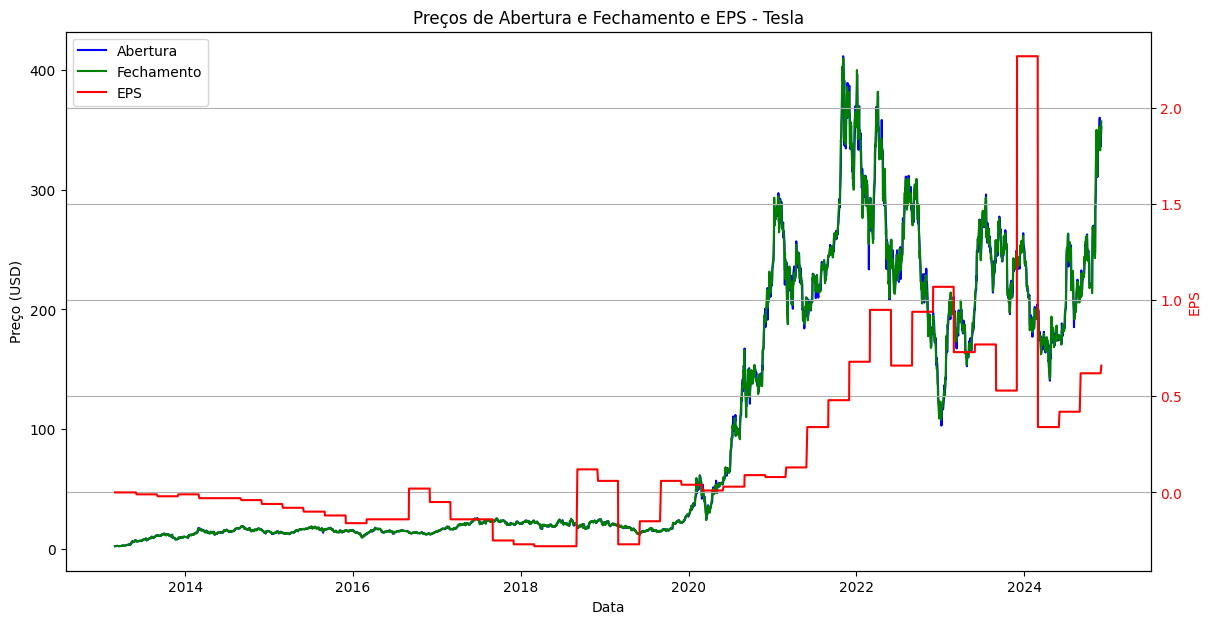

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtra os dados da Tesla
tesla_data = all_merged[all_merged['Company'] == 'Tesla'].copy()

# Converte a coluna Date para datetime (caso ainda não esteja)
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])

# Ordena os dados por data
tesla_data = tesla_data.sort_values('Date')

# Cria a figura e o eixo principal (para preços)
fig, ax1 = plt.subplots(figsize=(14,7))

# Plota os preços de abertura e fechamento no eixo esquerdo
ax1.plot(tesla_data['Date'], tesla_data['Open'], label='Abertura', color='blue')
ax1.plot(tesla_data['Date'], tesla_data['Close'], label='Fechamento', color='green')
ax1.set_xlabel("Data")
ax1.set_ylabel("Preço (USD)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Cria um eixo secundário para a receita (Revenue)
ax2 = ax1.twinx()
ax2.plot(tesla_data['Date'], tesla_data['EPS'], label='EPS', color='red')
ax2.set_ylabel("EPS", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título do gráfico
plt.title("Preços de Abertura e Fechamento e EPS - Tesla")

# Combina as legendas de ambos os eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.show()


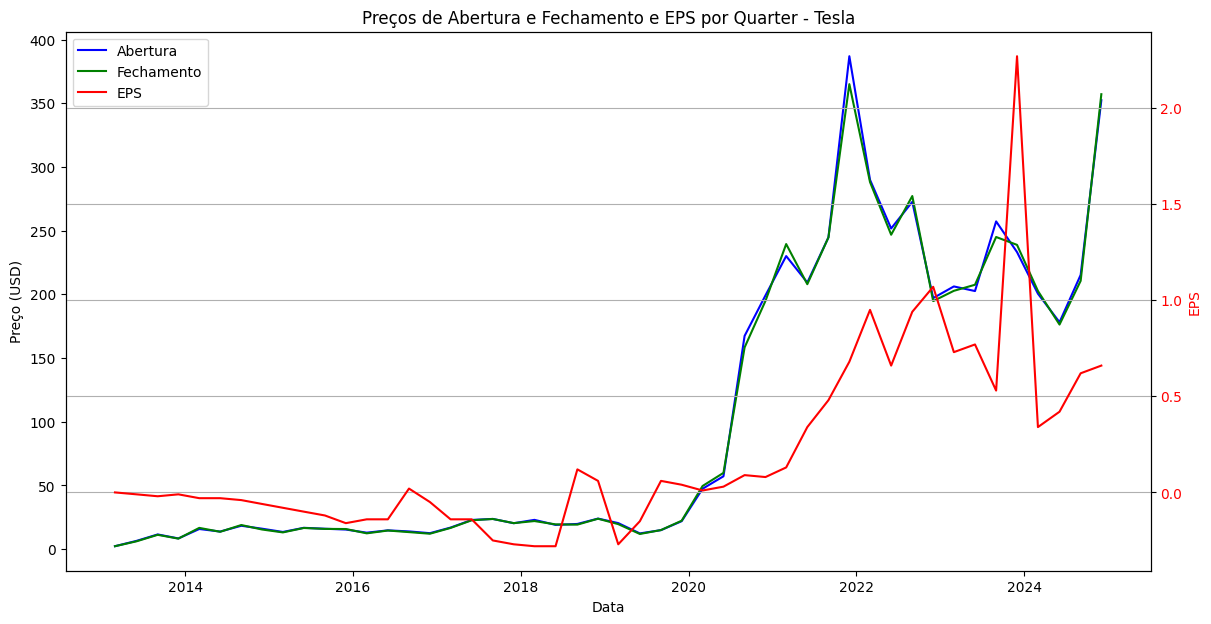

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtra os dados da Tesla
tesla_data = quarters_df[quarters_df['Company'] == 'Tesla'].copy()

# Converte a coluna Date para datetime (caso ainda não esteja)
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])

# Ordena os dados por data
tesla_data = tesla_data.sort_values('Date')

# Cria a figura e o eixo principal (para preços)
fig, ax1 = plt.subplots(figsize=(14,7))

# Plota os preços de abertura e fechamento no eixo esquerdo
ax1.plot(tesla_data['Date'], tesla_data['Open'], label='Abertura', color='blue')
ax1.plot(tesla_data['Date'], tesla_data['Close'], label='Fechamento', color='green')
ax1.set_xlabel("Data")
ax1.set_ylabel("Preço (USD)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Cria um eixo secundário para a receita (Revenue)
ax2 = ax1.twinx()
ax2.plot(tesla_data['Date'], tesla_data['EPS'], label='EPS', color='red')
ax2.set_ylabel("EPS", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título do gráfico
plt.title("Preços de Abertura e Fechamento e EPS por Quarter - Tesla")

# Combina as legendas de ambos os eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True)
plt.show()


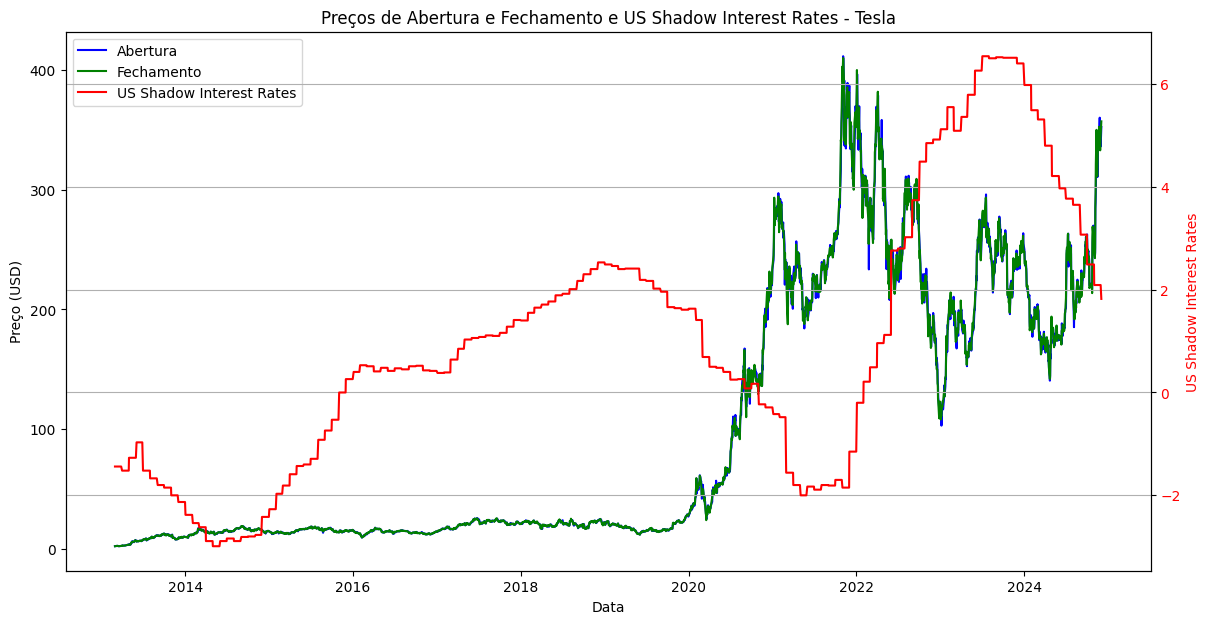

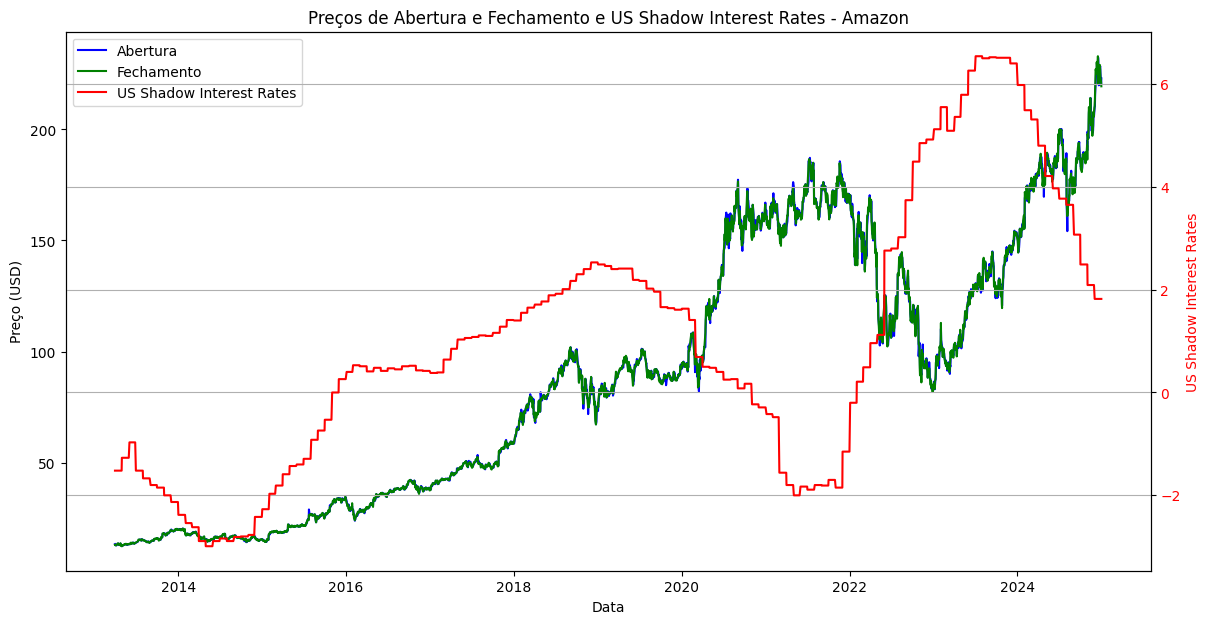

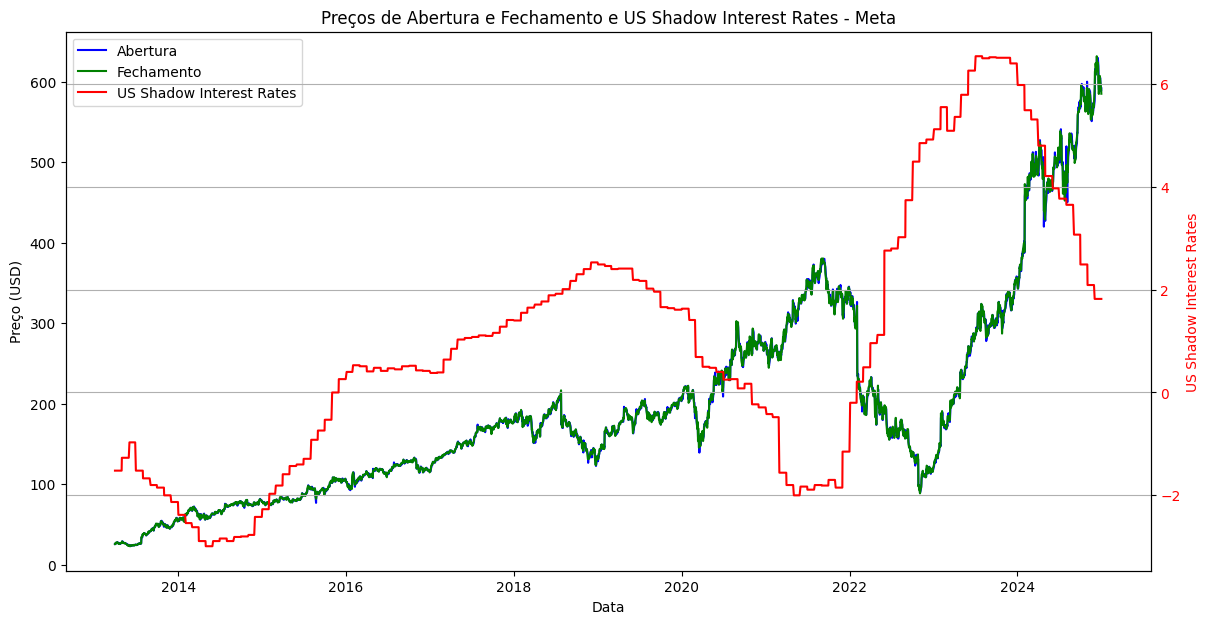

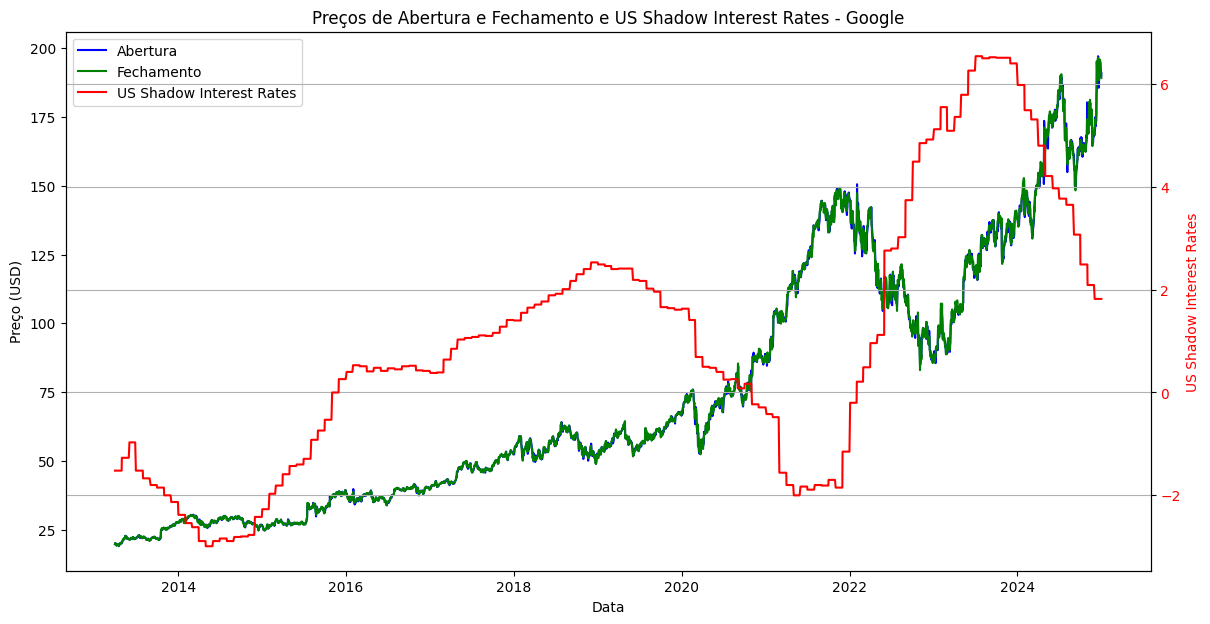

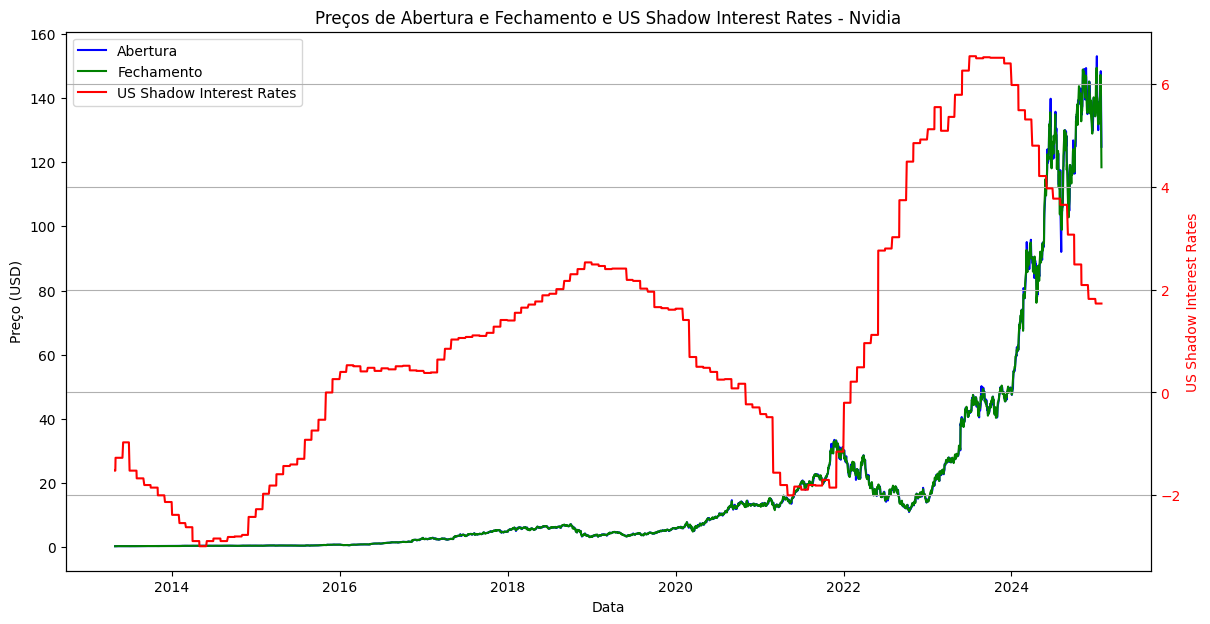

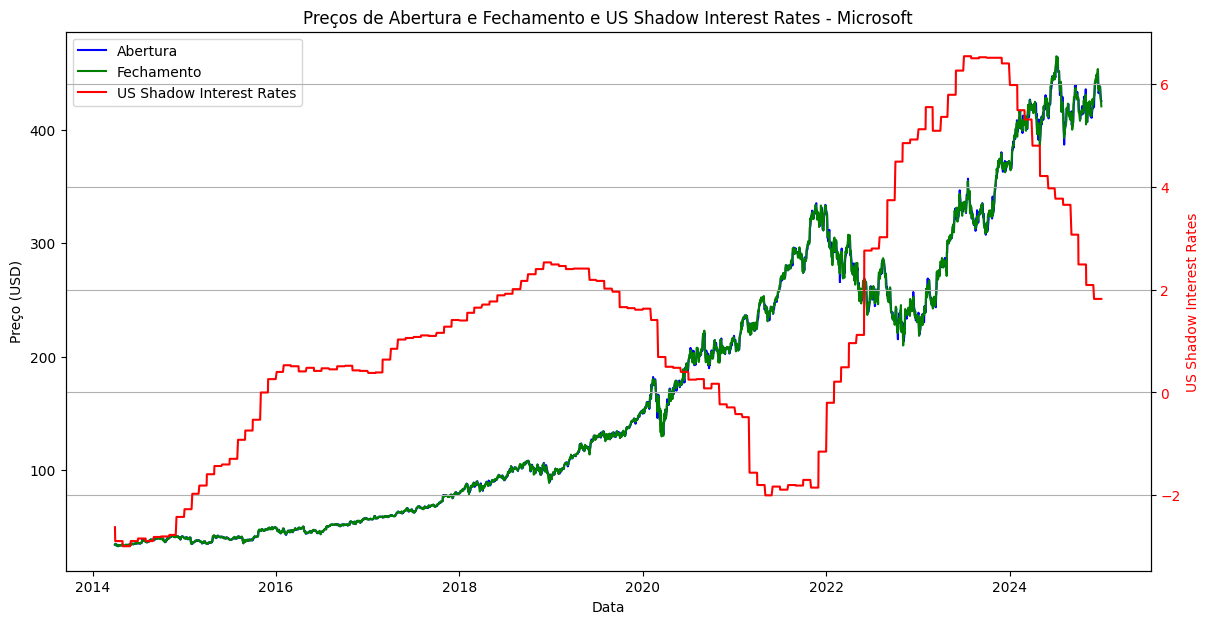

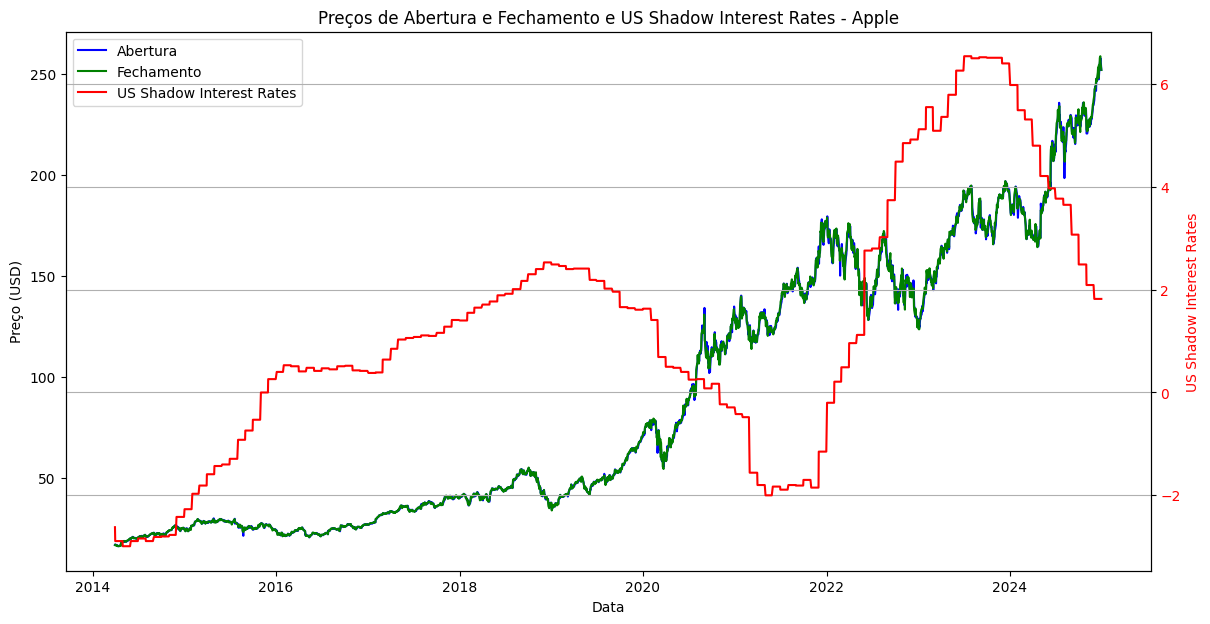

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
for company in merged_df['Company'].unique():

        # Filtra os dados da Tesla
        tesla_data = merged_df[merged_df['Company'] == company].copy()

        # Converte a coluna Date para datetime (caso ainda não esteja)
        tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])

        # Ordena os dados por data
        tesla_data = tesla_data.sort_values('Date')

        # Cria a figura e o eixo principal (para preços)
        fig, ax1 = plt.subplots(figsize=(14,7))

        # Plota os preços de abertura e fechamento no eixo esquerdo
        ax1.plot(tesla_data['Date'], tesla_data['Open'], label='Abertura', color='blue')
        ax1.plot(tesla_data['Date'], tesla_data['Close'], label='Fechamento', color='green')
        ax1.set_xlabel("Data")
        ax1.set_ylabel("Preço (USD)", color='black')
        ax1.tick_params(axis='y', labelcolor='black')

        # Cria um eixo secundário para a receita (Revenue)
        ax2 = ax1.twinx()
        ax2.plot(tesla_data['Date'], tesla_data['shadow_rate_final'], label='US Shadow Interest Rates', color='red')
        ax2.set_ylabel("US Shadow Interest Rates", color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Título do gráfico
        plt.title(f"Preços de Abertura e Fechamento e US Shadow Interest Rates - {company}")

        # Combina as legendas de ambos os eixos
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.grid(True)
        plt.show()


# Teste PSY

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.1 MB/s eta 0:00:00


In [ ]:
# Instale as bibliotecas se não tiver
# !pip install arch pandas numpy statsmodels

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings('ignore')

def adf_right_tailed(series, max_lags=3):
    """
    Retorna estatística ADF e número de lags selecionado, mas para
    uma alternativa: 'serie explosiva' (ou 'raiz unitária à direita').

    Usamos a função ADF do statsmodels, mas interpretamos a estatística
    de forma invertida. A lógica exata de 'right-tailed'
    dependerá de como iremos comparar com valores críticos.
    """
    # statsmodels adfuller: "regression='ct', 'c' ou 'nc'"
    # Para sem intercepto, reg: 'nc'.
    # Ajustar conforme necessidade:
    res = adfuller(series, maxlag=max_lags, regression='c', autolag=None)
    # res = (statistic, pvalue, usedlag, nobs, critical_values, icbest)
    adf_stat = res[0]
    return adf_stat

def get_gsadf(series, r0=0.01, max_lags=3):
    """
    Implementa o teste GSADF conforme PWY (2011),
    varrendo janelas [r1, r2], com r2 in [r0, 1], r1 in [0, r2 - r0].

    - series: pandas Series univariada, index temporal
    - r0: fração mínima de tamanho de subamostra (por ex. 0.01 ou 0.10)
    - max_lags: número de defasagens para ADF

    Retorna:
      - gsadf_stat: sup_{r1, r2} ADF
      - adf_store: dicionário ou lista com estatísticas ADF de cada subjanela
    """
    n = len(series)
    ts_data = series.values  # numpy array

    # Tamanhos min/max de amostra
    r0_count = int(np.floor(r0 * n))
    gsadf_val = -np.inf

    # Armazena estatísticas por (r1, r2) se quiser "mapear"
    adf_results = []

    # Loop em r2
    for r2_frac in np.arange(r0, 1.001, 0.01):  # ex.: passo de 0.01; ajustável
        r2_count = int(np.floor(r2_frac * n))
        if r2_count <= r0_count:
            continue

        # Em PWY, r1 varia de 0 a r2 - r0
        r1_min_frac = 0
        r1_max_frac = r2_frac - r0
        if r1_max_frac < 0:
            continue

        for r1_frac in np.arange(r1_min_frac, r1_max_frac+1e-9, 0.01):
            r1_count = int(np.floor(r1_frac * n))
            if r2_count - r1_count <= r0_count:
                # subamostra pequena
                continue

            sub_data = ts_data[r1_count:r2_count]
            # Aplica ADF "right-tailed" p/ explosão:
            adf_stat = adf_right_tailed(sub_data, max_lags=max_lags)

            # Atualiza sup
            if adf_stat > gsadf_val:
                gsadf_val = adf_stat

            adf_results.append((r1_frac, r2_frac, adf_stat))

    return gsadf_val, adf_results

# -----------------------
# Exemplo de uso:
# -----------------------
def run_pwy_gsadf_test(all_merged,
                       company_list=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                       r0=0.10, max_lags=3):
    """
    Faz o teste GSADF (PWY) para cada empresa, usando 'Close'
    como preços, e retorna estatísticas.
    - r0=0.10 => subamostra inicial = 10% do total
    """

    results_summary = []

    for comp in company_list:
        df_temp = all_merged[all_merged['Company']==comp].copy()

        # Ordena por data
        df_temp.sort_values('Date', inplace=True)
        df_temp.set_index('Date', inplace=True)

        # Pegamos a coluna de 'Close' e removemos NaN
        ts_close = df_temp['Close'].dropna()
        n = len(ts_close)
        if n < 50:
            print(f"{comp}: poucos dados ({n}). Pulando.")
            continue

        # Aplica o teste:
        gsadf_stat, all_adfs = get_gsadf(ts_close, r0=r0, max_lags=max_lags)

        results_summary.append({
            'Company': comp,
            'GSADF_stat': gsadf_stat,
            'NumObservations': n
        })

    return pd.DataFrame(results_summary)

# -----------------------------------------------
# Exemplo: Uso com "all_merged"
# -----------------------------------------------

# Supondo que "all_merged" é um DataFrame com colunas:
#   [ 'Date', 'Close', 'Company', ... ]
# e que já tenha sido carregado:

df_gsadf = run_pwy_gsadf_test(all_merged, r0=0.10, max_lags=3)
print(df_gsadf)


     Company  GSADF_stat  NumObservations
0      Apple    2.919017             2707
1  Microsoft    3.162011             2708
2     Amazon    2.969544             2960
3       Meta    1.913805             2960
4     Google    2.952021             2960
5     Nvidia    6.802146             2956
6      Tesla    7.800916             2960


## Teste PSY with Bubble Intervals

### Não Fixadas

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_right_tailed(series, max_lags=3):
    """
    Calcula a estatística ADF de 'statsmodels'
    (hipótese nula: raiz unitária), mas interpretada
    para hipótese alternativa explosiva (δ>1).

    Retorna somente o valor da estatística ADF (sem p-value).
    """
    # ADF do statsmodels (por default, teste left-tailed).
    # Ajustar o 'regression' conforme queira intercepto (c) ou não (nc).
    res = adfuller(series, maxlag=max_lags, regression='c', autolag=None)
    adf_stat = res[0]
    return adf_stat

def find_bubble_intervals(series, r0=0.05, step=0.01, max_lags=2, crit_value=2.0):
    """
    Identifica subjanelas (r1, r2) nas quais a estatística ADF
    sinaliza explosividade acima de um valor crítico.

    - series: pandas.Series com o 'Close' (por ex.), indexado por datas
    - r0: fração mínima de subamostra (ex. 0.10 => 10% do total)
    - step: passo para varredura (por ex. 0.01 => incrementa 1%)
    - max_lags: número de defasagens no ADF
    - crit_value: valor crítico de corte para caracterizar explosão

    Retorna:
      - bubble_subwindows: lista de dicionários com
           'r1_frac', 'r2_frac', 'start_date', 'end_date', 'adf_stat'
         indicando subintervalos possíveis de bolha.
    """
    n = len(series)
    data_values = series.values
    data_index = series.index

    # Tamanho absoluto do menor bloco
    min_len = int(np.floor(r0 * n))

    bubble_subwindows = []

    # Loop principal em r2
    r2_list = np.arange(r0, 1.0000001, step)
    for r2_frac in r2_list:
        r2_count = int(np.floor(r2_frac * n))
        if r2_count <= min_len:
            continue

        # Em PWY, r1 varia de 0 até r2 - r0
        r1_max_frac = r2_frac - r0
        if r1_max_frac < 0:
            continue

        r1_list = np.arange(0, r1_max_frac + 1e-9, step)
        for r1_frac in r1_list:
            r1_count = int(np.floor(r1_frac * n))
            sub_len = r2_count - r1_count
            if sub_len <= min_len:
                # janela muito pequena
                continue

            # Extrair subamostra e rodar ADF
            sub_data = data_values[r1_count : r2_count]
            adf_stat = adf_right_tailed(sub_data, max_lags=max_lags)

            # Se a estatística ADF ultrapassa 'crit_value', armazenar
            if adf_stat > crit_value:
                # Convertendo para datas do índice
                start_date = data_index[r1_count]
                end_date   = data_index[r2_count - 1]  # -1 pois r2_count é ponto "após"

                bubble_subwindows.append({
                    'r1_frac': round(r1_frac, 3),
                    'r2_frac': round(r2_frac, 3),
                    'start_date': start_date,
                    'end_date': end_date,
                    'adf_stat': adf_stat
                })

    return bubble_subwindows

def analyze_bubbles_for_each_company(all_merged,
                                     companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                                     r0=0.10, step=0.01, max_lags=3, crit_value=2.5):
    """
    Aplica a função find_bubble_intervals a cada empresa e retorna um dicionário
    com subintervalos de bolha (se existirem) para cada ticker.

    - all_merged: DataFrame com ['Date','Close','Company'] etc.
    - companies: lista de nomes das empresas
    - r0, step, max_lags, crit_value: parâmetros do teste

    Retorna:
      - dict[company] = list de subjanelas com explosão detectada
    """
    results = {}

    for comp in companies:
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp = df_temp.sort_values('Date')
        df_temp.set_index('Date', inplace=True)

        # Série de 'Close' (ou outra se preferir)
        ts_close = df_temp['Close'].dropna()

        if len(ts_close) < 50:
            print(f"Poucos dados para {comp}, pulando.")
            results[comp] = []
            continue

        subwindows = find_bubble_intervals(ts_close,
                                           r0=r0,
                                           step=step,
                                           max_lags=max_lags,
                                           crit_value=crit_value)
        results[comp] = subwindows

    return results


# Exemplo de uso:
results_dict = analyze_bubbles_for_each_company(all_merged,
                                companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                                r0=0.10,
                                step=0.01,
                                max_lags=3,
                                crit_value=2.5)
#
for comp, intervals in results_dict.items():
    print(f"\nEmpresa: {comp}")
    if not intervals:
        print("  Nenhum subperíodo acima do valor crítico escolhido.")
    else:
        for iv in intervals:
            print(f"  {iv}")



Empresa: Apple
  {'r1_frac': np.float64(0.0), 'r2_frac': np.float64(0.59), 'start_date': Timestamp('2014-03-31 00:00:00'), 'end_date': Timestamp('2020-07-31 00:00:00'), 'adf_stat': np.float64(2.8404773440242432)}
  {'r1_frac': np.float64(0.01), 'r2_frac': np.float64(0.59), 'start_date': Timestamp('2014-05-08 00:00:00'), 'end_date': Timestamp('2020-07-31 00:00:00'), 'adf_stat': np.float64(2.8799448170389668)}
  {'r1_frac': np.float64(0.02), 'r2_frac': np.float64(0.59), 'start_date': Timestamp('2014-06-17 00:00:00'), 'end_date': Timestamp('2020-07-31 00:00:00'), 'adf_stat': np.float64(2.8893020620085967)}
  {'r1_frac': np.float64(0.03), 'r2_frac': np.float64(0.59), 'start_date': Timestamp('2014-07-25 00:00:00'), 'end_date': Timestamp('2020-07-31 00:00:00'), 'adf_stat': np.float64(2.904174919431935)}
  {'r1_frac': np.float64(0.04), 'r2_frac': np.float64(0.59), 'start_date': Timestamp('2014-09-03 00:00:00'), 'end_date': Timestamp('2020-07-31 00:00:00'), 'adf_stat': np.float64(2.8677548557

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_bubble_intervals_with_stock(results_dict, all_merged):
    # Define os limites do gráfico no eixo x
    start_plot = pd.Timestamp("2013-01-01")
    end_plot = pd.Timestamp("2024-12-31")

    for company, intervals in results_dict.items():
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.set_xlim(start_plot, end_plot)
        ax1.set_xlabel("Data")
        ax1.set_ylabel("ADF Stat (Bolhas)", color='blue')

        # Cria a lista de datas de mudança (boundaries) com os limites do gráfico e os intervalos
        boundaries = [start_plot, end_plot]
        for iv in intervals:
            boundaries.append(iv['start_date'])
            boundaries.append(iv['end_date'])
        boundaries = sorted(set(boundaries))

        # Prepara os pontos para o gráfico de degraus
        times = []
        adf_values = []
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i+1]
            midpoint = seg_start + (seg_end - seg_start) / 2
            # Seleciona os adf_stat dos intervalos ativos neste segmento (ou seja, que cobrem o ponto médio)
            candidate_values = [iv['adf_stat'] for iv in intervals if iv['start_date'] <= midpoint <= iv['end_date']]
            if candidate_values:
                value = max(candidate_values)
            else:
                value = np.nan  # ou 0, se preferir
            times.append(seg_start)
            adf_values.append(value)

        # Acrescenta o último ponto para fechar a linha
        times.append(boundaries[-1])
        adf_values.append(np.nan)

        # Plota o gráfico de bolhas usando step (degraus)
        ax1.step(times, adf_values, where='post', label=f"{company} - ADF Stat", color='blue')
        ax1.grid(True)
        ax1.legend(loc='upper left')

        # Cria o eixo secundário para o preço de fechamento
        ax2 = ax1.twinx()
        ax2.set_ylabel("Preço de Fechamento", color='red')

        # Filtra o DataFrame para a empresa atual e garante que a coluna 'Date' seja datetime
        df_company = all_merged[all_merged['Company'] == company].copy()
        df_company['Date'] = pd.to_datetime(df_company['Date'])
        df_company = df_company.sort_values('Date')

        # Plota a linha de preço de fechamento
        ax2.plot(df_company['Date'], df_company['Close'], label=f"{company} - Fechamento", color='red')
        ax2.legend(loc='upper right')

        plt.title(f"Intervalos de Bolha e Preço de Fechamento - {company}")
        plt.show()

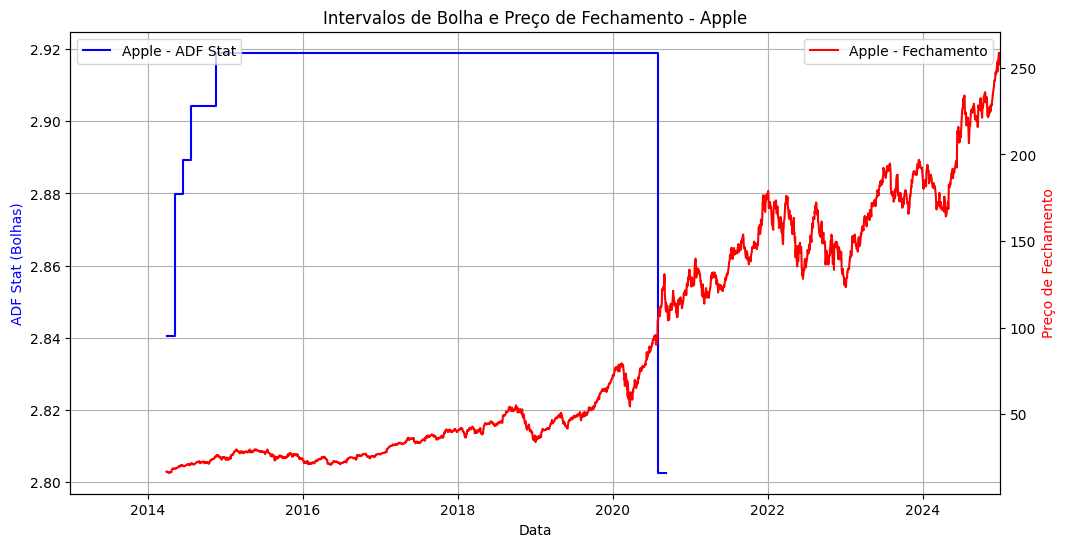

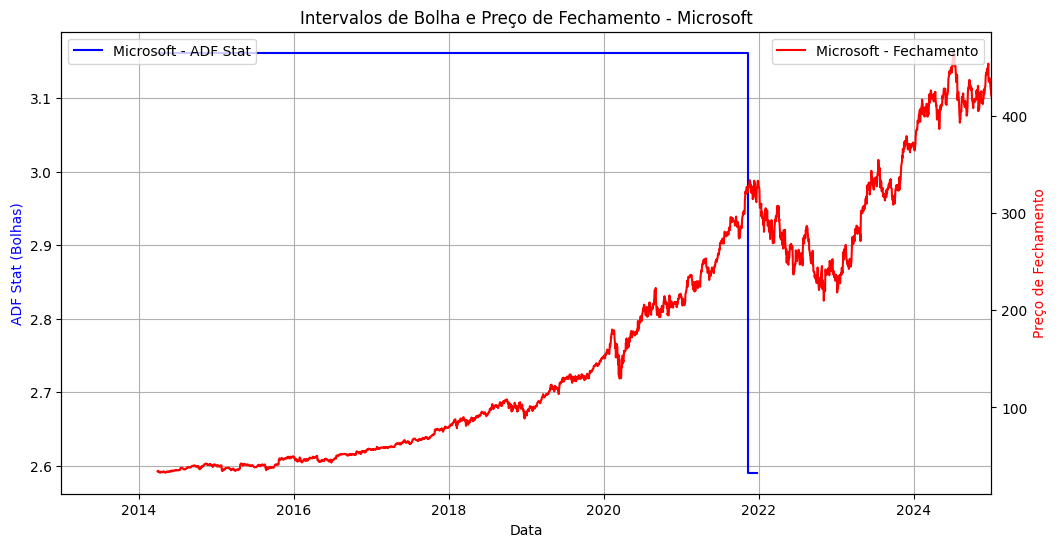

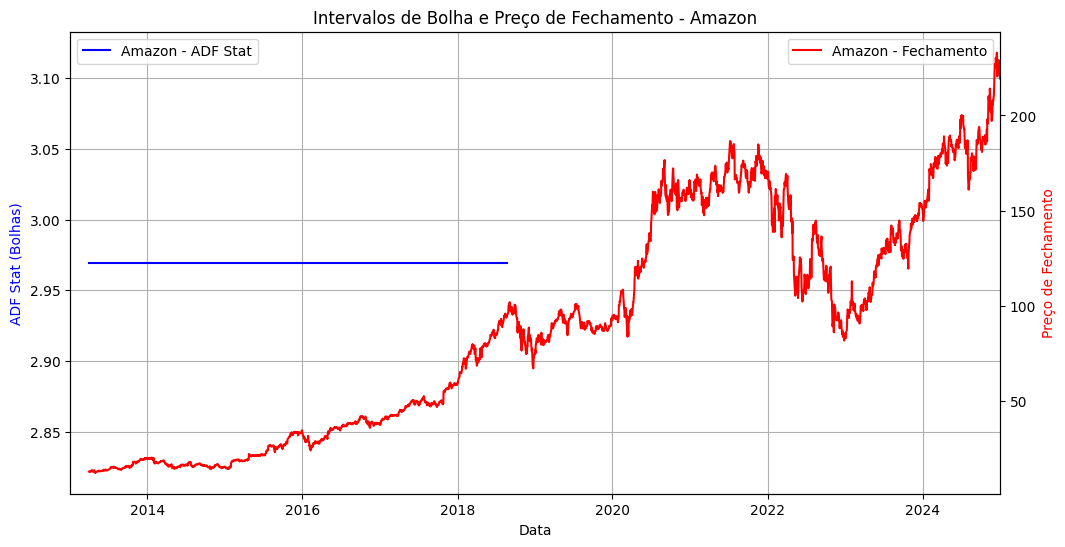

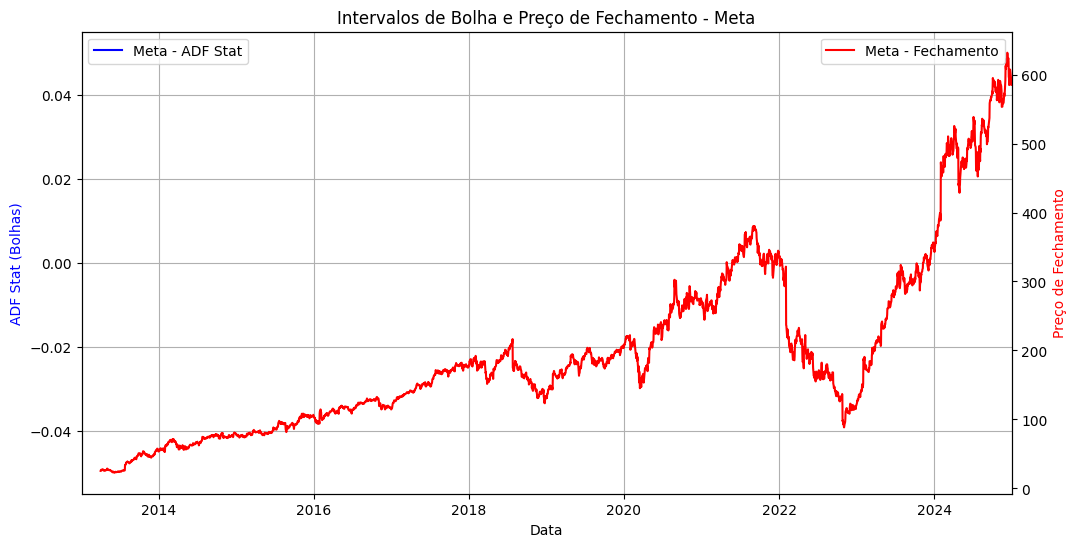

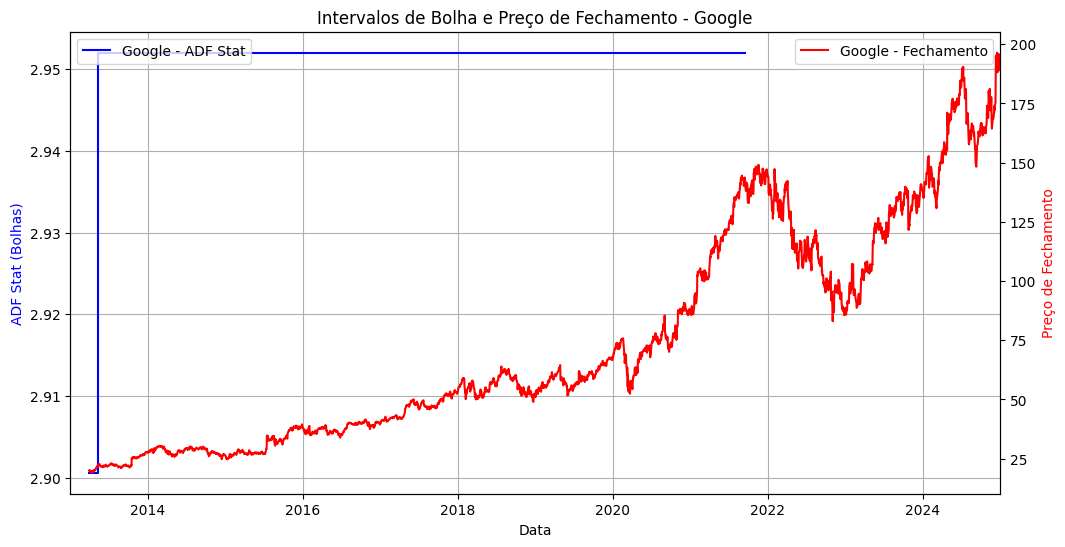

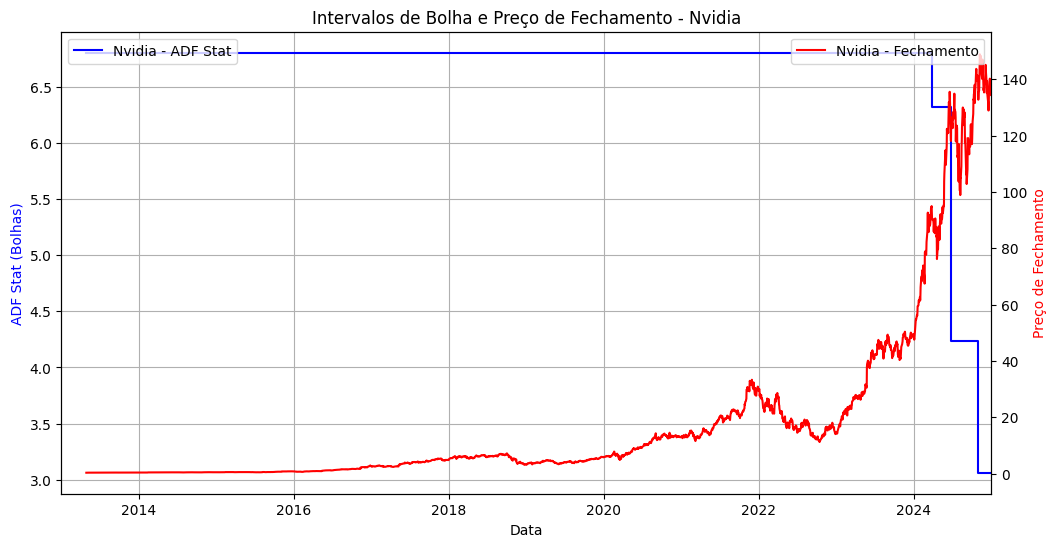

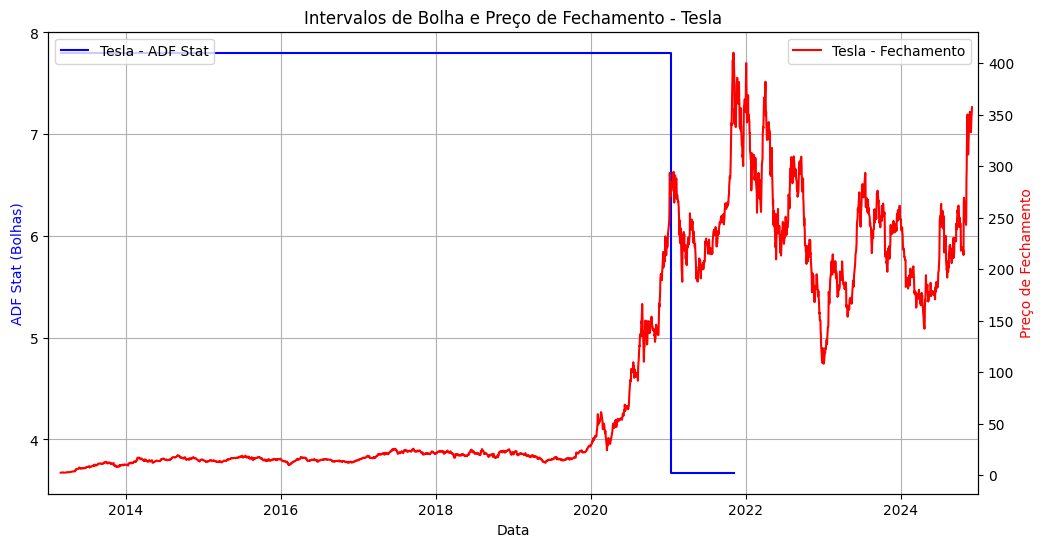

In [ ]:
# Chama a função para plotar os gráficos
plot_bubble_intervals_with_stock(results_dict, all_merged)

### Fixadas no final do período

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_right_tailed(series, max_lags=3):
    """
    Calcula a estatística ADF (hipótese nula: raiz unitária),
    mas interpretada para a alternativa explosiva (delta>1).
    """
    res = adfuller(series, maxlag=max_lags, regression='c', autolag=None)
    return res[0]

def find_bubble_intervals_focus_end(series,
                                    r0=0.10,
                                    r2_min=0.80,
                                    step=0.01,
                                    max_lags=3,
                                    crit_value=2.5):
    """
    Versão que concentra a busca de bolhas no final da série,
    impondo que r2 >= r2_min. Assim, cada subamostra termina
    necessariamente em >= r2_min do total de dados.

    - series: pandas.Series indexada por datas
    - r0: fração mínima de subamostra
    - r2_min: fração mínima do ponto final (por ex. 0.8 => 80% da amostra)
    - step: passo para varrer r2 e r1
    - max_lags: defasagens no ADF
    - crit_value: corte da estatística para declarar explosão

    Retorna subjanelas que excedem crit_value.
    """
    n = len(series)
    data_values = series.values
    data_index = series.index

    min_len = int(np.floor(r0 * n))

    bubble_subwindows = []

    # Agora r2 começa em r2_min, não em r0
    for r2_frac in np.arange(r2_min, 1.0000001, step):
        r2_count = int(np.floor(r2_frac * n))
        if r2_count <= min_len:
            continue

        r1_max_frac = r2_frac - r0
        if r1_max_frac < 0:
            continue

        # varredura r1
        r1_list = np.arange(0, r1_max_frac + 1e-9, step)
        for r1_frac in r1_list:
            r1_count = int(np.floor(r1_frac * n))
            sub_len = r2_count - r1_count
            if sub_len <= min_len:
                continue

            sub_data = data_values[r1_count:r2_count]
            adf_stat = adf_right_tailed(sub_data, max_lags=max_lags)

            if adf_stat > crit_value:
                start_date = data_index[r1_count]
                end_date   = data_index[r2_count - 1]
                bubble_subwindows.append({
                    'r1_frac': round(r1_frac, 3),
                    'r2_frac': round(r2_frac, 3),
                    'start_date': start_date,
                    'end_date': end_date,
                    'adf_stat': adf_stat
                })

    return bubble_subwindows

def analyze_bubbles_focus_end(all_merged,
                              companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                              r0=0.10,
                              r2_min=0.80,
                              step=0.01,
                              max_lags=3,
                              crit_value=2.5):
    """
    Aplica find_bubble_intervals_focus_end a cada empresa.
    """
    results = {}
    for comp in companies:
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp.sort_values('Date', inplace=True)
        df_temp.set_index('Date', inplace=True)

        ts_close = df_temp['Close'].dropna()
        if len(ts_close) < 50:
            print(f"{comp}: poucos dados, pulando.")
            results[comp] = []
            continue

        subwindows = find_bubble_intervals_focus_end(ts_close,
                                                     r0=r0,
                                                     r2_min=r2_min,
                                                     step=step,
                                                     max_lags=max_lags,
                                                     crit_value=crit_value)
        results[comp] = subwindows

    return results


res_end = analyze_bubbles_focus_end(all_merged,
                                    r0=0.10,
                                    r2_min=0.80,  # ex.: subamostras terminando em no mínimo 80% do dataset
                                    step=0.01,
                                    max_lags=3,
                                    crit_value=2.5)

for comp, intervals in res_end.items():
    print(f"\nEmpresa: {comp}, subintervalos detectados (r2 >= 80%):")
    for iv in intervals:
        print(" ", iv)


Empresa: Apple, subintervalos detectados (r2 >= 80%):

Empresa: Microsoft, subintervalos detectados (r2 >= 80%):

Empresa: Amazon, subintervalos detectados (r2 >= 80%):

Empresa: Meta, subintervalos detectados (r2 >= 80%):

Empresa: Google, subintervalos detectados (r2 >= 80%):

Empresa: Nvidia, subintervalos detectados (r2 >= 80%):
  {'r1_frac': np.float64(0.0), 'r2_frac': np.float64(0.87), 'start_date': Timestamp('2013-04-29 00:00:00'), 'end_date': Timestamp('2023-07-13 00:00:00'), 'adf_stat': np.float64(3.0531673882841424)}
  {'r1_frac': np.float64(0.01), 'r2_frac': np.float64(0.87), 'start_date': Timestamp('2013-06-10 00:00:00'), 'end_date': Timestamp('2023-07-13 00:00:00'), 'adf_stat': np.float64(3.026083940425579)}
  {'r1_frac': np.float64(0.02), 'r2_frac': np.float64(0.87), 'start_date': Timestamp('2013-07-23 00:00:00'), 'end_date': Timestamp('2023-07-13 00:00:00'), 'adf_stat': np.float64(2.9969646404947223)}
  {'r1_frac': np.float64(0.03), 'r2_frac': np.float64(0.87), 'start_d

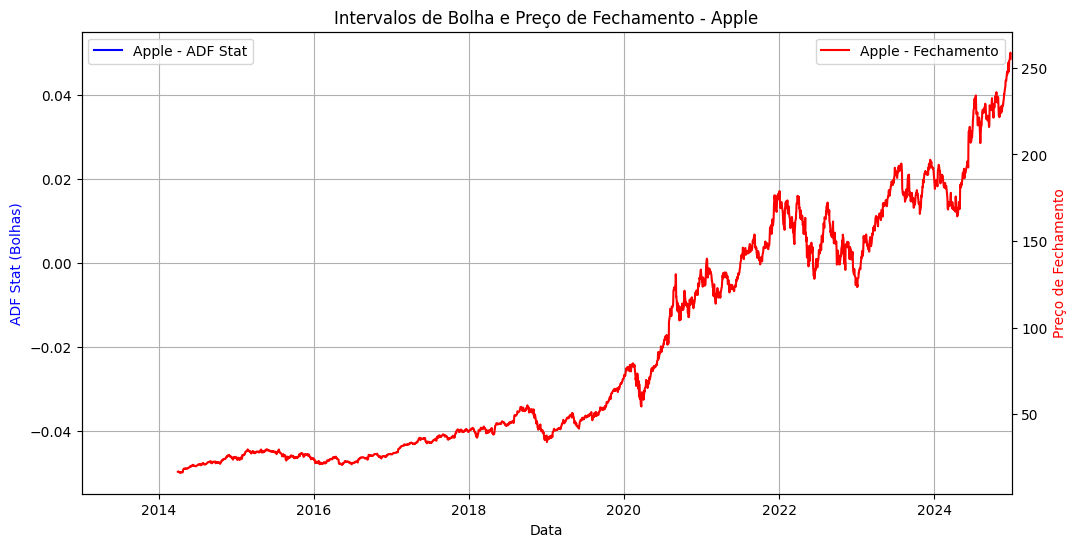

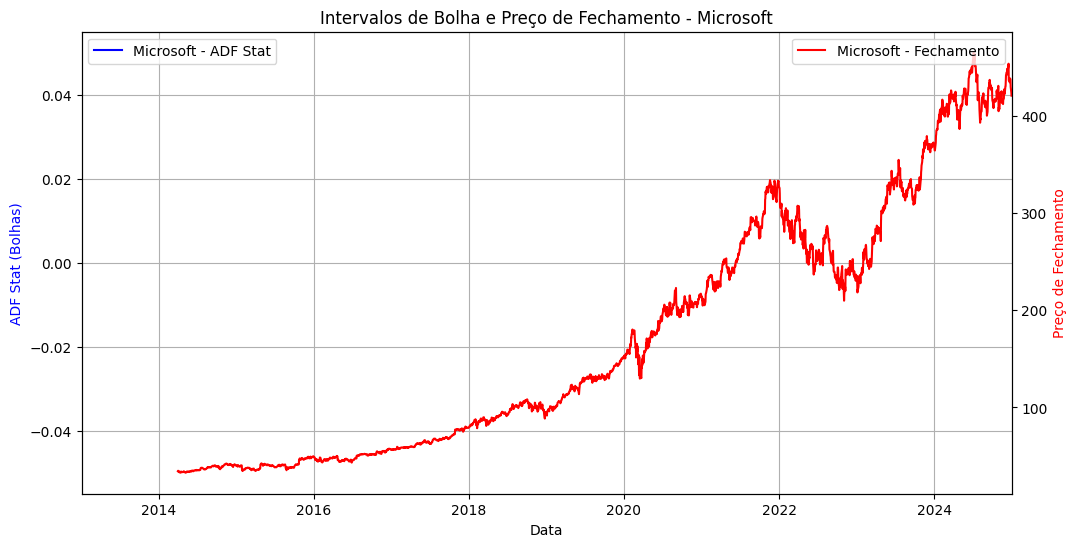

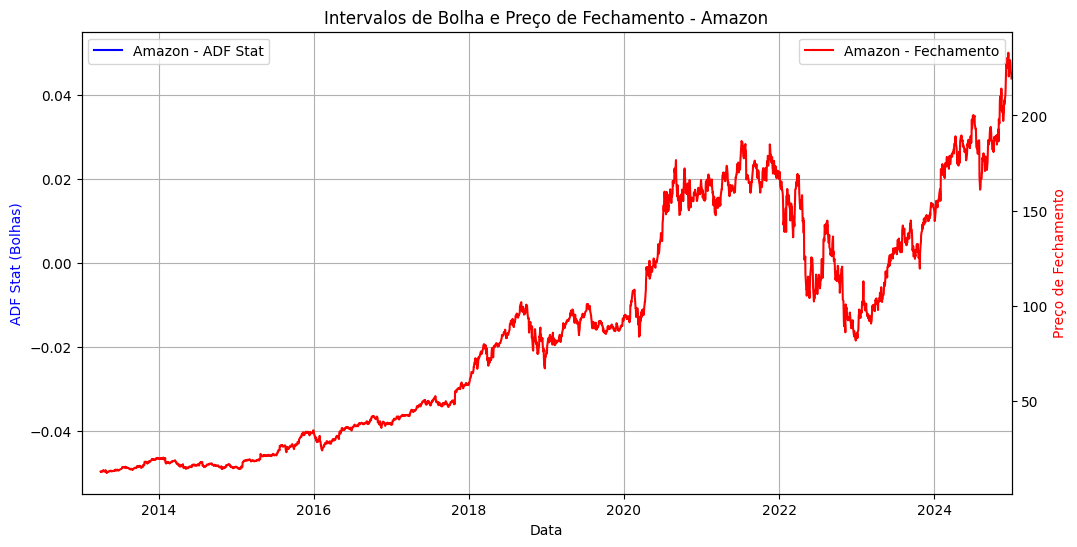

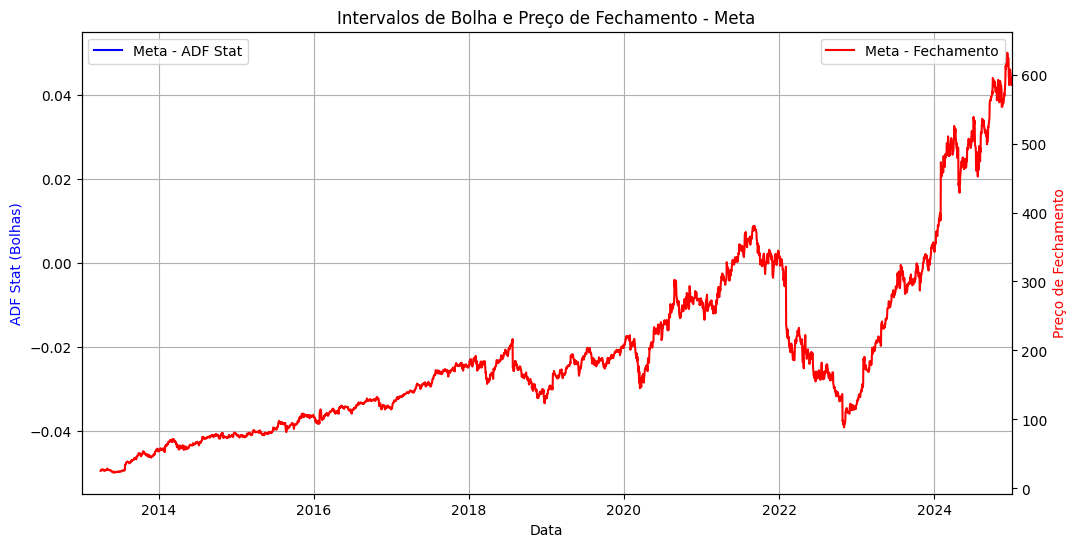

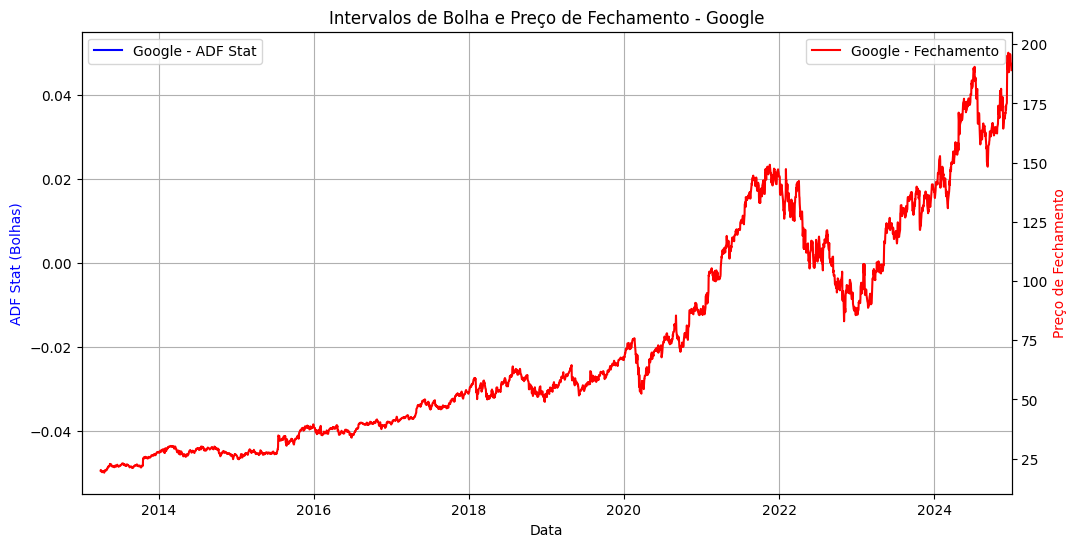

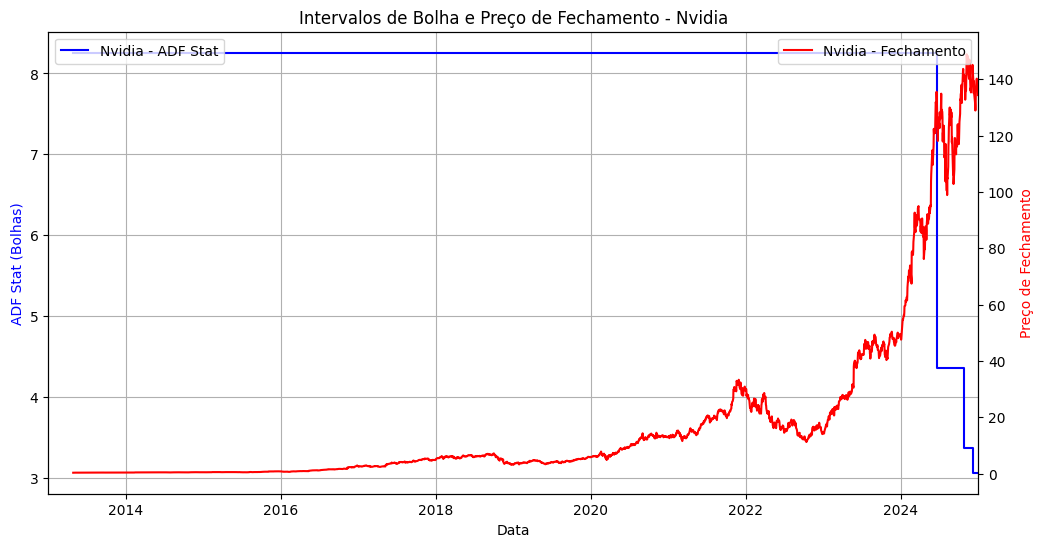

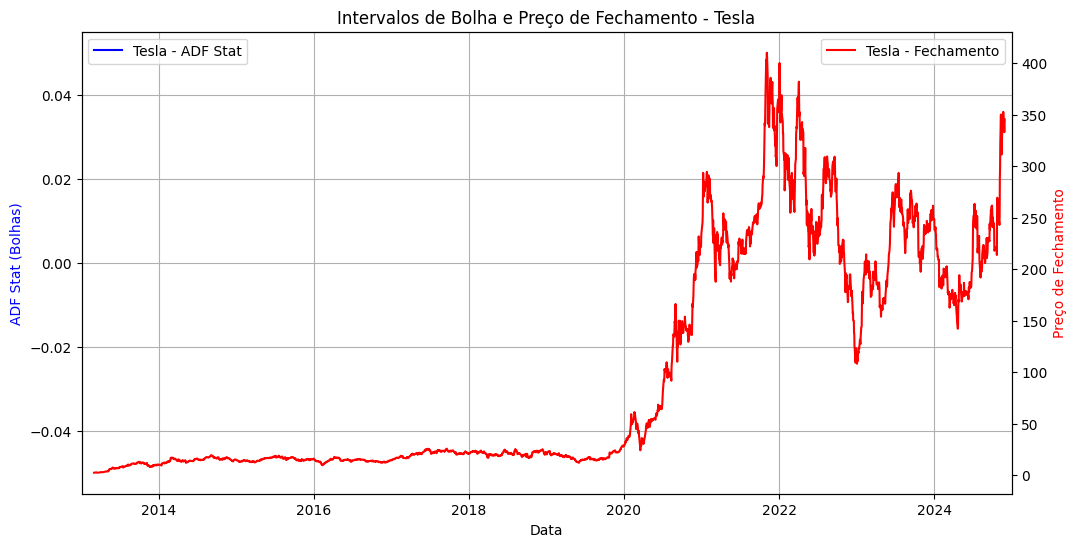

In [ ]:
# Chama a função para plotar os gráficos
plot_bubble_intervals_with_stock(res_end, all_merged)

### Janela Fixada em 3 anos

In [ ]:
def find_bubble_rolling_window(series,
                               window_size=252,
                               step=1,
                               max_lags=3,
                               crit_value=2.5):
    """
    Desliza (roll) uma janela fixa de tamanho 'window_size' ao longo de 'series'.
    Em cada janela, calcula adf_right_tailed e verifica se > crit_value.

    - window_size: quantos pontos cada janela contém (p.ex., ~750 para ~3 anos)
    - step: passo em observações para mover a janela
    - max_lags: defasagens ADF
    - crit_value: corte p/ explosão

    Retorna lista de dict, cada qual indicando [start_date, end_date, adf_stat].
    """
    n = len(series)
    data_values = series.values
    data_index = series.index

    bubble_windows = []

    # varremos start de 0 até n - window_size
    start = 0
    while start + window_size <= n:
        end = start + window_size
        sub_data = data_values[start:end]
        adf_stat = adf_right_tailed(sub_data, max_lags=max_lags)

        if adf_stat > crit_value:
            start_date = data_index[start]
            end_date   = data_index[end - 1]
            bubble_windows.append({
                'start_idx': start,
                'end_idx': end - 1,
                'start_date': start_date,
                'end_date': end_date,
                'adf_stat': adf_stat
            })

        start += step

    return bubble_windows

def analyze_bubbles_rolling(all_merged,
                            companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                            window_size=750,
                            step=1,
                            max_lags=3,
                            crit_value=2.5):
    """
    Aplica a função find_bubble_rolling_window a cada empresa.
    """
    results = {}
    for comp in companies:
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp.sort_values('Date', inplace=True)
        df_temp.set_index('Date', inplace=True)

        ts_close = df_temp['Close'].dropna()
        if len(ts_close) < window_size:
            print(f"{comp}: dados insuficientes para rolling window.")
            results[comp] = []
            continue

        subwins = find_bubble_rolling_window(ts_close,
                                             window_size=window_size,
                                             step=step,
                                             max_lags=max_lags,
                                             crit_value=crit_value)
        results[comp] = subwins

    return results

res_rolling = analyze_bubbles_rolling(all_merged,
                                      window_size=750, # ~3 anos
                                      step=20,  # mover a cada ~20 pregões
                                      max_lags=3,
                                      crit_value=2.5)

for comp, intervals in res_rolling.items():
    print(f"\nEmpresa: {comp}, rolling windows explosivas:")
    for iv in intervals:
        print(" ", iv)



Empresa: Apple, rolling windows explosivas:
  {'start_idx': 860, 'end_idx': 1609, 'start_date': Timestamp('2017-08-28 00:00:00'), 'end_date': Timestamp('2020-08-19 00:00:00'), 'adf_stat': np.float64(2.608833288323247)}

Empresa: Microsoft, rolling windows explosivas:

Empresa: Amazon, rolling windows explosivas:

Empresa: Meta, rolling windows explosivas:

Empresa: Google, rolling windows explosivas:

Empresa: Nvidia, rolling windows explosivas:
  {'start_idx': 80, 'end_idx': 829, 'start_date': Timestamp('2013-08-21 00:00:00'), 'end_date': Timestamp('2016-08-11 00:00:00'), 'adf_stat': np.float64(3.1329541411955013)}
  {'start_idx': 120, 'end_idx': 869, 'start_date': Timestamp('2013-10-17 00:00:00'), 'end_date': Timestamp('2016-10-07 00:00:00'), 'adf_stat': np.float64(2.8832686841779123)}
  {'start_idx': 160, 'end_idx': 909, 'start_date': Timestamp('2013-12-13 00:00:00'), 'end_date': Timestamp('2016-12-05 00:00:00'), 'adf_stat': np.float64(3.2251925274012114)}
  {'start_idx': 180, 'end

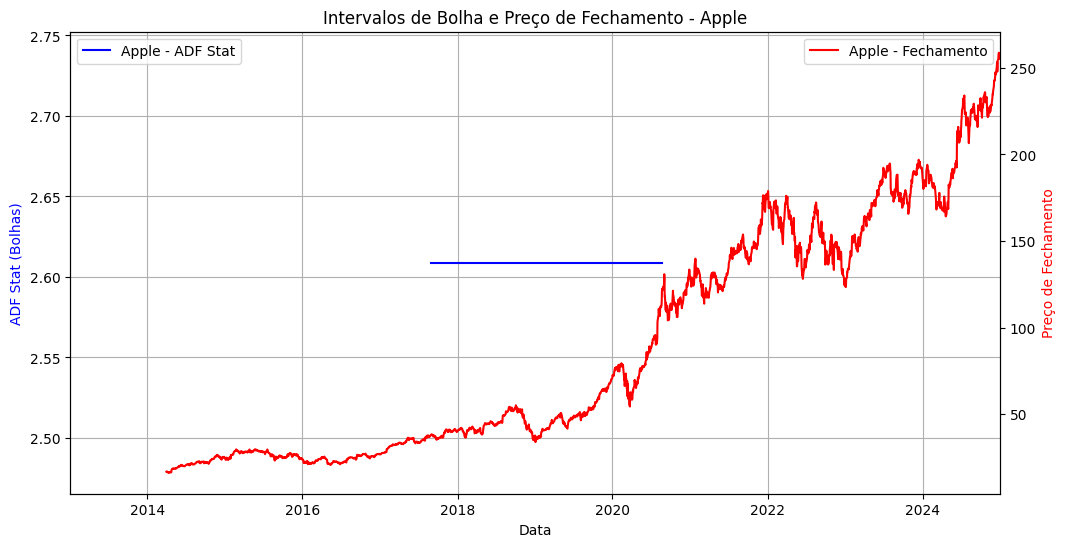

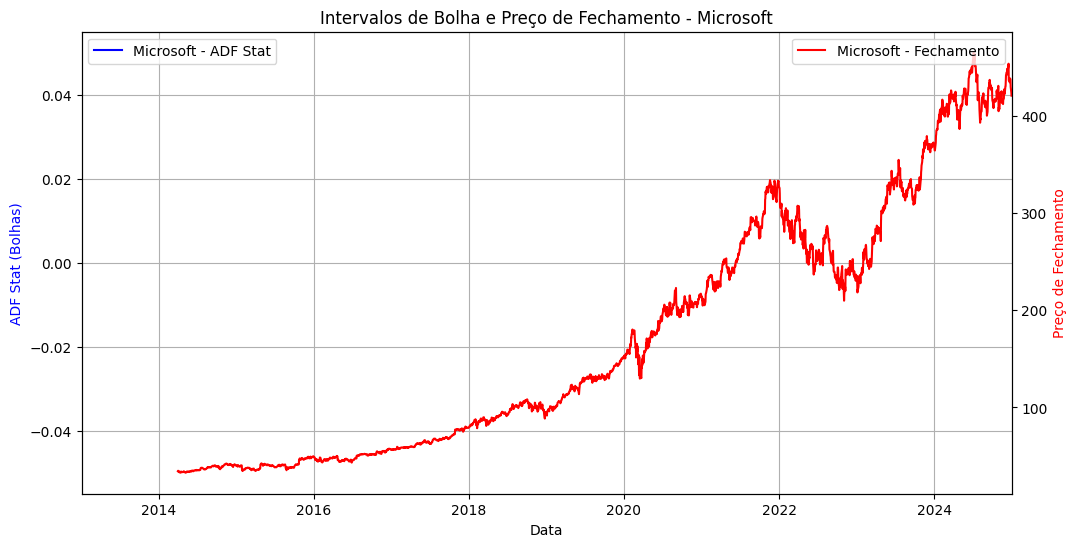

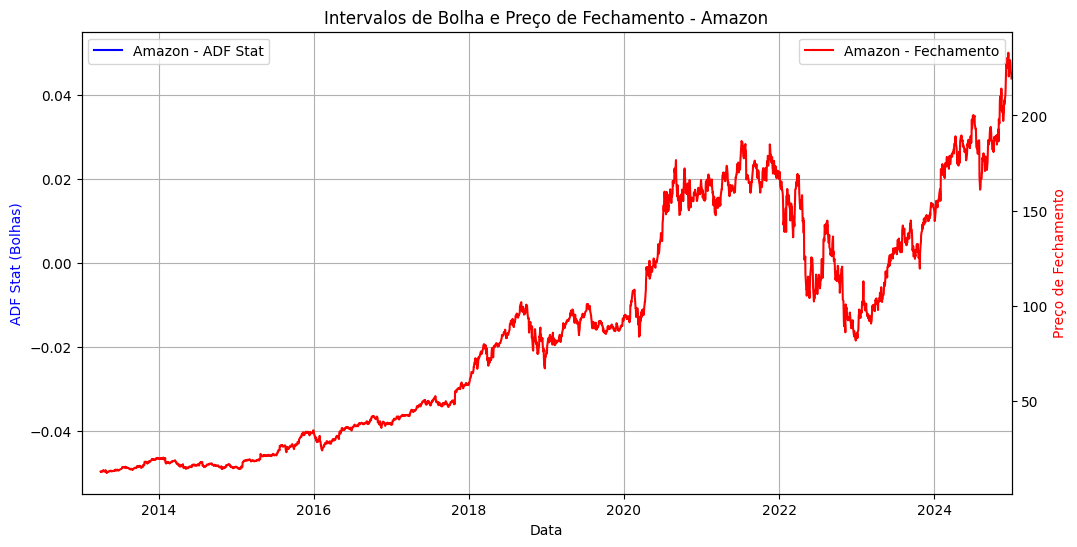

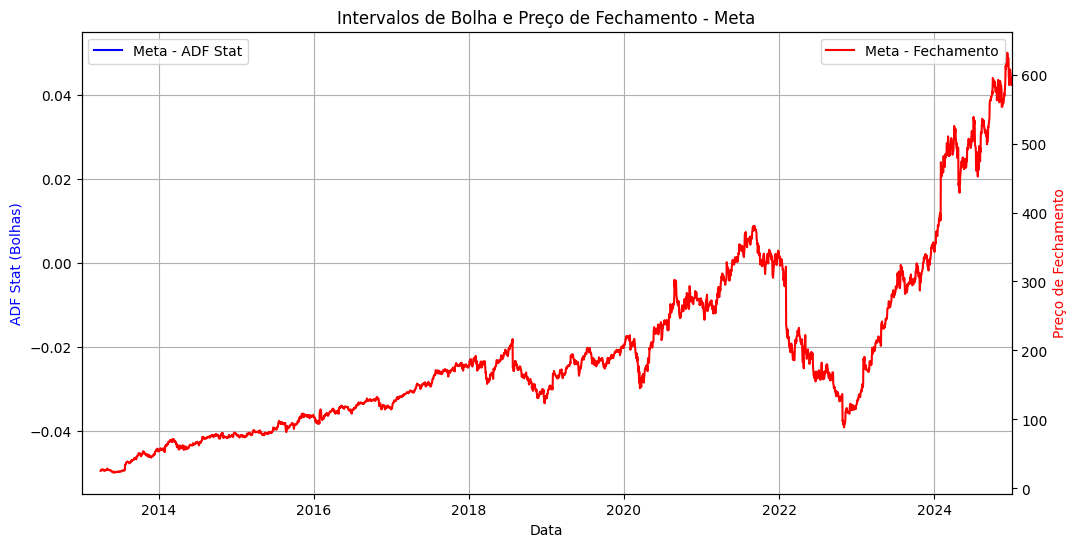

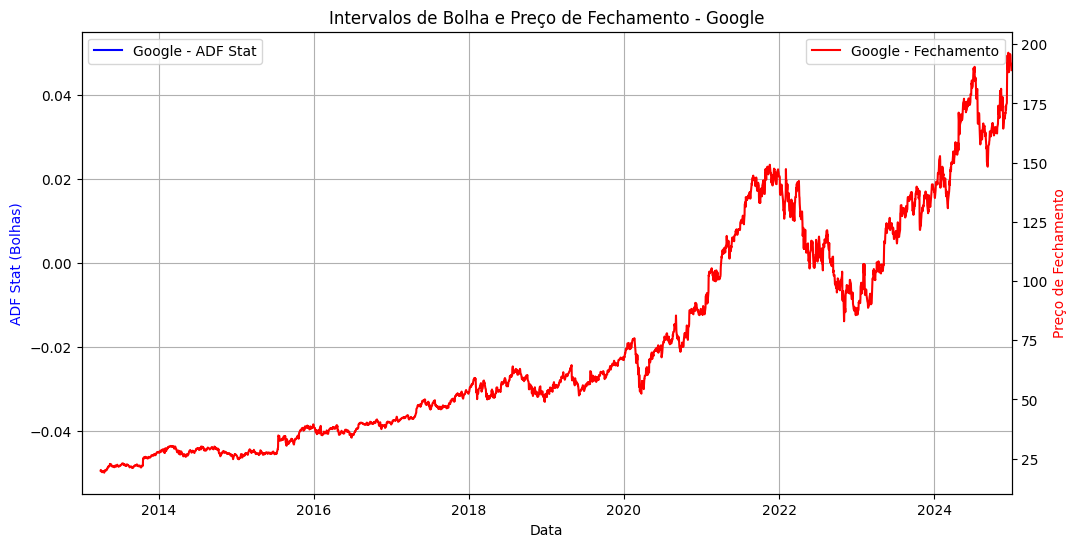

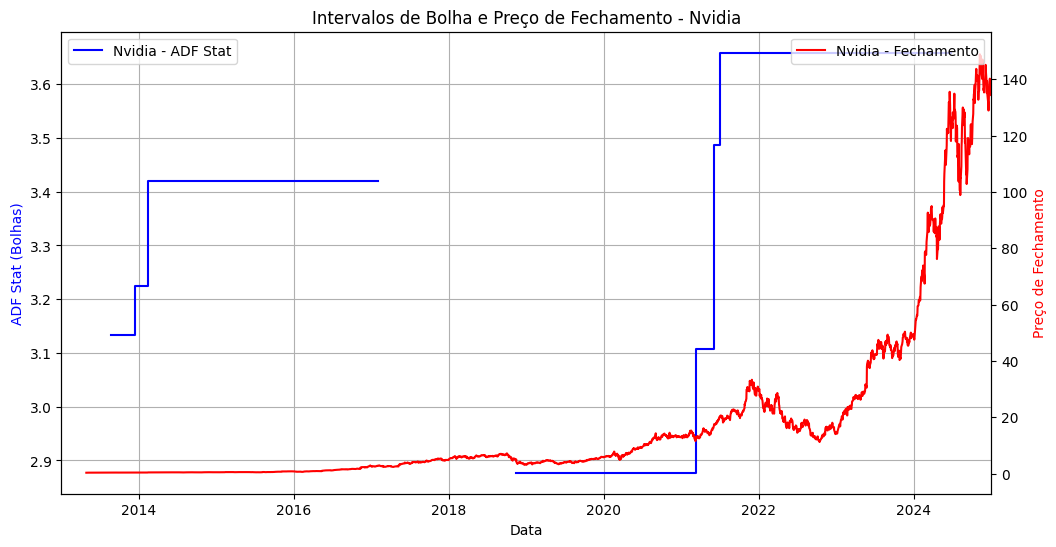

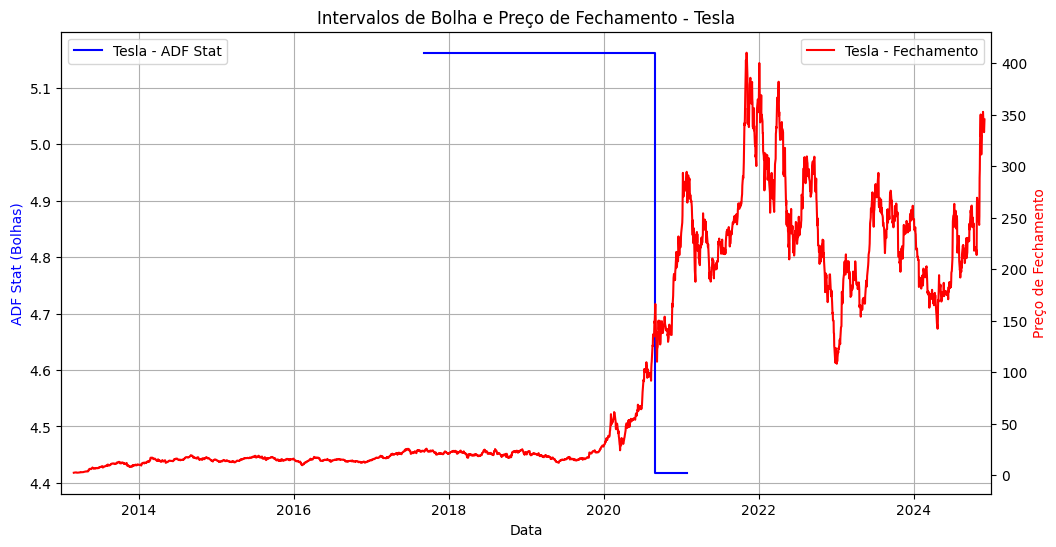

In [ ]:
# Chama a função para plotar os gráficos
plot_bubble_intervals_with_stock(res_rolling, all_merged)

### Fixadas no Final E Fixa

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_right_tailed(series, max_lags=3):
    """
    Calcula a estatística ADF (hipótese nula: raiz unitária),
    mas interpretada com a alternativa explosiva (delta > 1).
    Retorna apenas a estatística ADF.
    """
    res = adfuller(series, maxlag=max_lags, regression='c', autolag=None)
    return res[0]

def find_bubble_rolling_focus_end(series,
                                  window_size=750,
                                  step=1,
                                  r2_min=0.80,
                                  max_lags=3,
                                  crit_value=2.5):
    """
    Combina rolling window (tamanho fixo) + restrição de r2_min.

    - window_size: quantidade fixa de observações na janela (p.ex. 750 ~ 3 anos diários)
    - step: quantos pontos avançar a cada iteração (p.ex. 1 => andar 1 dia)
    - r2_min: fração mínima (ex.: 0.8 => 80% do dataset). A janela precisa terminar em end
              tal que end/n >= r2_min.
    - max_lags: defasagens do ADF
    - crit_value: corte acima do qual consideramos que há explosividade

    Retorna uma lista de dicionários. Cada dicionário descreve a subjanela
    detectada como 'explosiva', com campos:
      'start_idx', 'end_idx', 'start_date', 'end_date', 'adf_stat'.
    """
    n = len(series)
    values = series.values
    idx = series.index

    bubble_windows = []

    # Limite inferior para 'end' em termos de índice
    # se end/n >= r2_min => end >= r2_min * n
    min_end_idx = int(np.ceil(r2_min * n))

    # Rolling: varremos o 'start' e calculamos 'end = start+window_size'.
    start = 0
    while True:
        end = start + window_size
        if end > n:
            break

        # Verifica se essa janela cumpre end >= min_end_idx
        if end < min_end_idx:
            # não atende a restrição de r2_min, ou seja,
            # a janela termina muito cedo => pula
            start += step
            continue

        # extrai a sub-série
        sub_data = values[start:end]
        adf_stat = adf_right_tailed(sub_data, max_lags=max_lags)

        if adf_stat > crit_value:
            bubble_windows.append({
                'start_idx': start,
                'end_idx': end - 1,
                'start_date': idx[start],
                'end_date': idx[end - 1],
                'adf_stat': adf_stat
            })
        start += step

    return bubble_windows

def analyze_bubbles_rolling_focus_end(all_merged,
                                      companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                                      window_size=750,  # ~3 anos
                                      step=1,
                                      r2_min=0.80,
                                      max_lags=3,
                                      crit_value=2.5):
    """
    Aplica find_bubble_rolling_focus_end a cada empresa do DF.
    - window_size: tamanho fixo da janela
    - step: passo de avanço
    - r2_min: exige que a janela termine em >= r2_min do dataset (foco no final)
    - max_lags, crit_value: parâmetros do ADF explosivo
    """
    results = {}
    for comp in companies:
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp.sort_values('Date', inplace=True)
        df_temp.set_index('Date', inplace=True)

        ts_close = df_temp['Close'].dropna()
        if len(ts_close) < window_size:
            print(f"{comp}: não há dados suficientes para a janela fixada ({window_size}). Pulando.")
            results[comp] = []
            continue

        subwins = find_bubble_rolling_focus_end(ts_close,
                                                window_size=window_size,
                                                step=step,
                                                r2_min=r2_min,
                                                max_lags=max_lags,
                                                crit_value=crit_value)
        results[comp] = subwins

    return results

results_dict = analyze_bubbles_rolling_focus_end(all_merged,
                                                 companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                                                 window_size=750,
                                                 step=5,
                                                 r2_min=0.80,
                                                 max_lags=3,
                                                 crit_value=2.5)

for comp, intervals in results_dict.items():
    print(f"\n{comp} => Janelas explosivas (rolling + focus end):")
    if not intervals:
        print("  Nenhuma encontrada.")
    else:
        for iv in intervals:
            print(" ", iv)



Apple => Janelas explosivas (rolling + focus end):
  Nenhuma encontrada.

Microsoft => Janelas explosivas (rolling + focus end):
  Nenhuma encontrada.

Amazon => Janelas explosivas (rolling + focus end):
  Nenhuma encontrada.

Meta => Janelas explosivas (rolling + focus end):
  Nenhuma encontrada.

Google => Janelas explosivas (rolling + focus end):
  Nenhuma encontrada.

Nvidia => Janelas explosivas (rolling + focus end):
  {'start_idx': 1975, 'end_idx': 2724, 'start_date': Timestamp('2021-03-03 00:00:00'), 'end_date': Timestamp('2024-02-23 00:00:00'), 'adf_stat': np.float64(2.6625720968389306)}
  {'start_idx': 1980, 'end_idx': 2729, 'start_date': Timestamp('2021-03-10 00:00:00'), 'end_date': Timestamp('2024-03-01 00:00:00'), 'adf_stat': np.float64(3.107475339264861)}
  {'start_idx': 1985, 'end_idx': 2734, 'start_date': Timestamp('2021-03-17 00:00:00'), 'end_date': Timestamp('2024-03-08 00:00:00'), 'adf_stat': np.float64(3.4494366923291615)}
  {'start_idx': 1990, 'end_idx': 2739, 'st

### Forçado

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_right_tailed(series, max_lags=3):
    """
    Calcula a estatística ADF (hipótese nula: raiz unitária),
    mas interpretada para a alternativa explosiva (delta > 1).
    Retorna apenas a estatística ADF.
    """
    res = adfuller(series, maxlag=max_lags, regression='c', autolag=None)
    return res[0]

def find_bubble_intervals(series, r0=0.10, step=0.01, max_lags=3, crit_value=2.5):
    """
    Identifica subjanelas (r1, r2) nas quais a estatística ADF
    sinaliza explosividade acima de um valor crítico.

    - series: pandas.Series com o 'Close' (por ex.), indexado por datas
    - r0: fração mínima de subamostra (ex. 0.10 => 10% do total)
    - step: passo para varredura (por ex. 0.01 => incrementa 1%)
    - max_lags: número de defasagens no ADF
    - crit_value: valor crítico para declarar explosão

    Retorna lista de dicionários com:
      'r1_frac', 'r2_frac', 'start_date', 'end_date', 'adf_stat'.
    """
    n = len(series)
    data_values = series.values
    data_index = series.index

    min_len = int(np.floor(r0 * n))
    bubble_subwindows = []

    r2_list = np.arange(r0, 1.0000001, step)
    for r2_frac in r2_list:
        r2_count = int(np.floor(r2_frac * n))
        if r2_count <= min_len:
            continue

        r1_max_frac = r2_frac - r0
        if r1_max_frac < 0:
            continue

        r1_list = np.arange(0, r1_max_frac + 1e-9, step)
        for r1_frac in r1_list:
            r1_count = int(np.floor(r1_frac * n))
            sub_len = r2_count - r1_count
            if sub_len <= min_len:
                continue

            sub_data = data_values[r1_count : r2_count]
            adf_stat = adf_right_tailed(sub_data, max_lags=max_lags)

            if adf_stat > crit_value:
                start_date = data_index[r1_count]
                end_date   = data_index[r2_count - 1]
                bubble_subwindows.append({
                    'r1_frac': round(r1_frac, 3),
                    'r2_frac': round(r2_frac, 3),
                    'start_date': start_date,
                    'end_date': end_date,
                    'adf_stat': adf_stat
                })

    return bubble_subwindows

def analyze_bubbles_for_each_company(all_merged,
                                     companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                                     r0=0.10,
                                     step=0.01,
                                     max_lags=3,
                                     crit_value=2.5):
    """
    Aplica find_bubble_intervals a cada empresa e retorna um dicionário
    com subintervalos de bolha detectados.
    """
    results = {}
    for comp in companies:
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp.sort_values('Date', inplace=True)
        df_temp.set_index('Date', inplace=True)

        ts_close = df_temp['Close'].dropna()
        if len(ts_close) < 50:
            print(f"[INFO] {comp}: poucos dados, pulando.")
            results[comp] = []
            continue

        subwins = find_bubble_intervals(ts_close,
                                        r0=r0,
                                        step=step,
                                        max_lags=max_lags,
                                        crit_value=crit_value)
        results[comp] = subwins

    return results


def grid_search_bubbles(
    all_merged,
    companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
    r0_values=[0.05, 0.10],
    step_values=[0.01, 0.02],
    max_lags_values=[2, 3],
    crit_values=[2.0, 2.5, 3.0],
):
    """
    Faz uma varredura (grid search) em diferentes parâmetros do find_bubble_intervals e
    registra quantos subintervalos explosivos cada empresa encontra.

    Retorna um DataFrame com as colunas:
      [Company, r0, step, max_lags, crit_value, num_explosive_windows]
    """
    all_results = []

    for r0_ in r0_values:
        for step_ in step_values:
            for mlags_ in max_lags_values:
                for cval_ in crit_values:
                    # Executa a análise para esse set de parâmetros
                    print(f"\n[GRID] Testando: r0={r0_}, step={step_}, max_lags={mlags_}, crit_value={cval_}")
                    result_dict = analyze_bubbles_for_each_company(all_merged,
                                                                   companies=companies,
                                                                   r0=r0_,
                                                                   step=step_,
                                                                   max_lags=mlags_,
                                                                   crit_value=cval_)

                    # Para cada empresa, conta quantos subintervalos foram detectados
                    for comp in companies:
                        subwins = result_dict.get(comp, [])
                        num_explosive = len(subwins)

                        all_results.append({
                            'Company': comp,
                            'r0': r0_,
                            'step': step_,
                            'max_lags': mlags_,
                            'crit_value': cval_,
                            'num_explosive_windows': num_explosive
                        })

    # Monta em DataFrame
    df_grid = pd.DataFrame(all_results)
    return df_grid


# ====== Exemplo de uso (principal) ======
if __name__ == "__main__":
    # Supondo que 'all_merged' já foi carregado e possui colunas ['Date','Close','Company']

    # 1) Defina os valores que deseja testar
    r0_values = [0.05, 0.10, 0.15]
    step_values = [0.01, 0.02]
    max_lags_values = [2, 3]
    crit_values = [2.0, 2.5, 3.0, 3.5]

    # 2) Roda o grid search
    df_result_grid = grid_search_bubbles(
        all_merged,
        companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
        r0_values=r0_values,
        step_values=step_values,
        max_lags_values=max_lags_values,
        crit_values=crit_values,
    )

    # 3) Inspeciona o DataFrame
    print("\n==== RESULTADOS GRID SEARCH ====")
    print(df_result_grid)

    # Exemplo: se quiser ver quais params geram mais bolhas para Nvidia
    df_nvidia = df_result_grid[df_result_grid['Company'] == 'Nvidia'].sort_values(
        'num_explosive_windows', ascending=False
    )
    print("\n=== Top Parametros para Nvidia ===")
    print(df_nvidia.head(10))



[GRID] Testando: r0=0.05, step=0.01, max_lags=2, crit_value=2.0

[GRID] Testando: r0=0.05, step=0.01, max_lags=2, crit_value=2.5

[GRID] Testando: r0=0.05, step=0.01, max_lags=2, crit_value=3.0

[GRID] Testando: r0=0.05, step=0.01, max_lags=2, crit_value=3.5

[GRID] Testando: r0=0.05, step=0.01, max_lags=3, crit_value=2.0

[GRID] Testando: r0=0.05, step=0.01, max_lags=3, crit_value=2.5

[GRID] Testando: r0=0.05, step=0.01, max_lags=3, crit_value=3.0

[GRID] Testando: r0=0.05, step=0.01, max_lags=3, crit_value=3.5

[GRID] Testando: r0=0.05, step=0.02, max_lags=2, crit_value=2.0

[GRID] Testando: r0=0.05, step=0.02, max_lags=2, crit_value=2.5

[GRID] Testando: r0=0.05, step=0.02, max_lags=2, crit_value=3.0

[GRID] Testando: r0=0.05, step=0.02, max_lags=2, crit_value=3.5

[GRID] Testando: r0=0.05, step=0.02, max_lags=3, crit_value=2.0

[GRID] Testando: r0=0.05, step=0.02, max_lags=3, crit_value=2.5

[GRID] Testando: r0=0.05, step=0.02, max_lags=3, crit_value=3.0

[GRID] Testando: r0=0.05

In [ ]:
# Número total de empresas no DataFrame
total_empresas = df_result_grid['Company'].nunique()

# Agrupar por conjunto de parâmetros e calcular estatísticas
df_grouped = df_result_grid.groupby(['r0', 'step', 'max_lags', 'crit_value']).agg(
    min_explosive=('num_explosive_windows', 'min'),
    sum_explosive=('num_explosive_windows', 'sum'),
    count_companies=('Company', 'nunique')
).reset_index()

# Filtrar os grupos onde:
# - Todas as empresas estão representadas (count_companies == total_empresas)
# - O valor mínimo de num_explosive_windows é pelo menos 1 (ou seja, para todas as empresas há pelo menos 1 bolha)
df_filtered = df_grouped[(df_grouped['count_companies'] == total_empresas) & (df_grouped['min_explosive'] >= 0)]

# Ordenar os resultados pela soma total dos num_explosive_windows de forma decrescente
df_filtered = df_filtered.sort_values('sum_explosive', ascending=False)

print("=== Conjuntos de Parâmetros com pelo menos 1 num_explosive_windows para cada empresa ===")
print(df_filtered)


=== Conjuntos de Parâmetros com pelo menos 1 num_explosive_windows para cada empresa ===
      r0  step  max_lags  crit_value  min_explosive  sum_explosive  \
0   0.05  0.01         2         2.0              0           1630   
16  0.10  0.01         2         2.0              0           1629   
32  0.15  0.01         2         2.0              0           1599   
4   0.05  0.01         3         2.0              0           1556   
20  0.10  0.01         3         2.0              0           1543   
36  0.15  0.01         3         2.0              0           1514   
17  0.10  0.01         2         2.5              0           1062   
1   0.05  0.01         2         2.5              0           1059   
33  0.15  0.01         2         2.5              0           1043   
5   0.05  0.01         3         2.5              0            949   
21  0.10  0.01         3         2.5              0            945   
37  0.15  0.01         3         2.5              0            936   
2

# Teste de Cointegração

## Quarters

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def engle_granger_coint_test(quarters_df,
                             company,
                             price_col='Close',
                             eps_col='EPS'):
    """
    Aplica o teste de Engle-Granger para checar a cointegração entre
    Preço e EPS de uma empresa específica, usando dados filtrados.

    - quarters_df: DataFrame contendo as colunas ['Date','Company','Close','EPS'],
      mas apenas nas datas em que o EPS está disponível.
    - company: nome da empresa (str)
    - price_col, eps_col: colunas que representam preço e EPS

    Retorna um dicionário com:
      'Company', 'ADF Statistic', 'p-value', 'Beta', 'Intercept', 'Obs', 'Conclusion'.
    """

    # Filtra o DF para a empresa
    df = quarters_df[quarters_df['Company'] == company].copy()
    df.sort_values('Date', inplace=True)

    # Remove NaN no preço/eps
    df = df.dropna(subset=[price_col, eps_col])

    Y = df[price_col].values  # série de preço
    X = df[eps_col].values    # série de eps

    if len(Y) < 20:
        return {
            'Company': company,
            'ADF Statistic': None,
            'p-value': None,
            'Beta': None,
            'Intercept': None,
            'Obs': len(Y),
            'Conclusion': "Dados insuficientes (menos de 20 pontos)"
        }

    # 1) OLS: Preço = alpha + beta * EPS
    X_ = sm.add_constant(X)
    model = sm.OLS(Y, X_).fit()
    intercept, beta = model.params

    # 2) Resíduos
    resid = Y - (intercept + beta*X)

    # 3) Teste ADF nos resíduos (sem intercepto, pois resid ~ 0)
    adf_result = adfuller(resid, regression='n')
    adf_stat = adf_result[0]
    p_value = adf_result[1]

    # 4) Interpretação
    if p_value < 0.05:
        conclusion = "Cointegração (p<0.05)"
    else:
        conclusion = "Sem Evidência de Cointegração (p>=0.05)"

    return {
        'Company': company,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Beta': beta,
        'Intercept': intercept,
        'Obs': len(Y),
        'Conclusion': conclusion
    }

def run_coint_tests_filtered(quarters_df,
                             companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                             price_col='Close',
                             eps_col='EPS'):
    """
    Aplica engle_granger_coint_test para cada empresa no DF filtrado (EPS + Preço)
    e retorna um DataFrame com os resultados.
    """
    results = []
    for comp in companies:
        res = engle_granger_coint_test(quarters_df, comp, price_col=price_col, eps_col=eps_col)
        results.append(res)

    return pd.DataFrame(results)

df_results = run_coint_tests_filtered(quarters_df,
    companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
    price_col='Close',
    eps_col='EPS')
print(df_results)


     Company  ADF Statistic       p-value        Beta  Intercept  Obs  \
0      Apple       0.308249  7.770913e-01  107.663153 -16.025258   44   
1  Microsoft      -5.643737  5.293097e-08  122.785054 -15.184865   44   
2     Amazon      -1.610956  1.011000e-01  102.713092  53.669721   48   
3       Meta      -6.497120  7.899281e-10   72.095784  51.230590   48   
4     Google      -4.147548  4.066725e-05   76.608238  14.667892   48   
5     Nvidia      -2.878148  3.918844e-03  148.796181   2.143558   48   
6      Tesla      -1.037393  2.732238e-01  180.247961  65.199580   48   

                                Conclusion  
0  Sem Evidência de Cointegração (p>=0.05)  
1                    Cointegração (p<0.05)  
2  Sem Evidência de Cointegração (p>=0.05)  
3                    Cointegração (p<0.05)  
4                    Cointegração (p<0.05)  
5                    Cointegração (p<0.05)  
6  Sem Evidência de Cointegração (p>=0.05)  


## Taxa de Juros como Variável Explicativa

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def engle_granger_coint_test_with_shadow_rates(
    quarters_df,
    company,
    price_col='Close',
    eps_col='EPS',
    sr_col='shadow_rate_final'
):
    """
    Aplica o teste de Engle-Granger para checar cointegração entre
    Preço, EPS e Shadow Rates, usando dados filtrados por empresa.

    - quarters_df: DataFrame contendo as colunas ['Date','Company','Close','EPS','shadow_rate_final'],
      podendo já estar no formato daily (com EPS replicado diariamente) ou apenas trimestral.
    - company: nome da empresa (str)
    - price_col, eps_col, sr_col: nomes das colunas que representam preço, EPS e Shadow Rates

    Retorna um dicionário com:
      'Company', 'ADF Statistic', 'p-value', 'Beta_EPS', 'Beta_SR', 'Intercept', 'Obs', 'Conclusion'.
    """

    # Filtra o DF para a empresa especificada
    df = quarters_df[quarters_df['Company'] == company].copy()
    df.sort_values('Date', inplace=True)

    # Remove NaN nas colunas relevantes
    df = df.dropna(subset=[price_col, eps_col, sr_col])

    # Se a amostra for muito pequena, retornamos mensagem de insuficiência
    if len(df) < 20:
        return {
            'Company': company,
            'ADF Statistic': None,
            'p-value': None,
            'Beta_EPS': None,
            'Beta_SR': None,
            'Intercept': None,
            'Obs': len(df),
            'Conclusion': "Dados insuficientes (menos de 20 pontos)"
        }

    # Séries
    Y = df[price_col].values
    X_eps = df[eps_col].values
    X_sr = df[sr_col].values

    # Monta a matriz de regressoras com intercepto
    X_ = sm.add_constant(  # Adiciona coluna de 1 para intercepto
        pd.DataFrame({
            'EPS': X_eps,
            'ShadowRate': X_sr
        })
    )

    # 1) OLS: Preço = alpha + beta1 * EPS + beta2 * ShadowRate
    model = sm.OLS(Y, X_).fit()
    intercept, beta_eps, beta_sr = model.params

    # 2) Cálculo dos resíduos
    resid = Y - (intercept + beta_eps * X_eps + beta_sr * X_sr)

    # 3) Teste ADF nos resíduos (sem intercepto no teste, pois resid ~ 0)
    adf_result = adfuller(resid, regression='n')
    adf_stat = adf_result[0]
    p_value = adf_result[1]

    # 4) Conclusão
    if p_value < 0.05:
        conclusion = "Cointegração (p<0.05)"
    else:
        conclusion = "Sem Evidência de Cointegração (p>=0.05)"

    return {
        'Company': company,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Beta_EPS': beta_eps,
        'Beta_SR': beta_sr,
        'Intercept': intercept,
        'Obs': len(df),
        'Conclusion': conclusion
    }
def run_coint_tests_filtered_with_shadow_rates(quarters_df,
                             companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                             price_col='Close',
                             eps_col='EPS',
                             sr_col='shadow_rate_final'):
    """
    Aplica engle_granger_coint_test para cada empresa no DF filtrado (EPS + Preço)
    e retorna um DataFrame com os resultados.
    """
    results = []
    for comp in companies:
        res = engle_granger_coint_test_with_shadow_rates(quarters_df, comp, price_col=price_col, eps_col=eps_col,sr_col=sr_col)
        results.append(res)

    return pd.DataFrame(results)

df_results = run_coint_tests_filtered_with_shadow_rates(quarters_df=quarters_df,
    companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
    price_col='Close',
    eps_col='EPS',
    sr_col='shadow_rate_final')
print(df_results)

     Company  ADF Statistic       p-value    Beta_EPS   Beta_SR  Intercept  \
0      Apple      -0.170639  6.247020e-01   97.278775  4.943703 -11.754033   
1  Microsoft      -5.445389  1.356811e-07  117.700813  3.734547 -11.846907   
2     Amazon      -1.627243  9.787518e-02   93.396886  4.672049  52.423152   
3       Meta      -6.814342  1.572746e-10   73.946499 -2.557677  49.891814   
4     Google      -4.424779  1.297564e-05   74.829821  0.789916  15.294795   
5     Nvidia      -3.140108  1.683899e-03  146.434435  0.434654   1.976503   
6      Tesla      -1.074855  2.551043e-01  185.344696 -1.743445  65.900770   

   Obs                               Conclusion  
0   44  Sem Evidência de Cointegração (p>=0.05)  
1   44                    Cointegração (p<0.05)  
2   48  Sem Evidência de Cointegração (p>=0.05)  
3   48                    Cointegração (p<0.05)  
4   48                    Cointegração (p<0.05)  
5   48                    Cointegração (p<0.05)  
6   48  Sem Evidência de 

## Todos os dias

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def engle_granger_coint_test(merged_df,
                             company,
                             price_col='Close',
                             eps_col='EPS'):
    """
    Aplica o teste de Engle-Granger para checar a cointegração entre
    Preço e EPS de uma empresa específica, usando dados filtrados.

    - merged_df: DataFrame contendo as colunas ['Date','Company','Close','EPS'],
      mas apenas nas datas em que o EPS está disponível.
    - company: nome da empresa (str)
    - price_col, eps_col: colunas que representam preço e EPS

    Retorna um dicionário com:
      'Company', 'ADF Statistic', 'p-value', 'Beta', 'Intercept', 'Obs', 'Conclusion'.
    """

    # Filtra o DF para a empresa
    df = merged_df[merged_df['Company'] == company].copy()
    df.sort_values('Date', inplace=True)

    # Remove NaN no preço/eps
    df = df.dropna(subset=[price_col, eps_col])

    Y = df[price_col].values  # série de preço
    X = df[eps_col].values    # série de eps

    if len(Y) < 20:
        return {
            'Company': company,
            'ADF Statistic': None,
            'p-value': None,
            'Beta': None,
            'Intercept': None,
            'Obs': len(Y),
            'Conclusion': "Dados insuficientes (menos de 20 pontos)"
        }

    # 1) OLS: Preço = alpha + beta * EPS
    X_ = sm.add_constant(X)
    model = sm.OLS(Y, X_).fit()
    intercept, beta = model.params

    # 2) Resíduos
    resid = Y - (intercept + beta*X)

    # 3) Teste ADF nos resíduos (sem intercepto, pois resid ~ 0)
    adf_result = adfuller(resid, regression='n')
    adf_stat = adf_result[0]
    p_value = adf_result[1]

    # 4) Interpretação
    if p_value < 0.05:
        conclusion = "Cointegração (p<0.05)"
    else:
        conclusion = "Sem Evidência de Cointegração (p>=0.05)"

    return {
        'Company': company,
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Beta': beta,
        'Intercept': intercept,
        'Obs': len(Y),
        'Conclusion': conclusion
    }

def run_coint_tests_filtered(merged_df,
                             companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
                             price_col='Close',
                             eps_col='EPS'):
    """
    Aplica engle_granger_coint_test para cada empresa no DF filtrado (EPS + Preço)
    e retorna um DataFrame com os resultados.
    """
    results = []
    for comp in companies:
        res = engle_granger_coint_test(merged_df, comp, price_col=price_col, eps_col=eps_col)
        results.append(res)

    return pd.DataFrame(results)

df_results = run_coint_tests_filtered(merged_df,
    companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
    price_col='Close',
    eps_col='EPS')
print(df_results)


     Company  ADF Statistic       p-value        Beta  Intercept   Obs  \
0      Apple      -3.982787  7.840710e-05  106.298806 -11.985791  2707   
1  Microsoft      -4.641093  5.159235e-06  122.674752 -11.270342  2708   
2     Amazon      -3.933959  9.492799e-05  110.762417  54.503586  2960   
3       Meta      -4.879702  1.811480e-06   76.581076  50.972985  2960   
4     Google      -5.865209  1.818061e-08   77.208276  16.572308  2960   
5     Nvidia      -4.287385  2.298793e-05  175.695800   1.773375  2956   
6      Tesla      -3.390449  7.144429e-04  168.296440  66.587685  2960   

              Conclusion  
0  Cointegração (p<0.05)  
1  Cointegração (p<0.05)  
2  Cointegração (p<0.05)  
3  Cointegração (p<0.05)  
4  Cointegração (p<0.05)  
5  Cointegração (p<0.05)  
6  Cointegração (p<0.05)  


## Gregory-Hansen

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def gregory_hansen_test(y, x, min_break=0.15, max_break=0.85, model='level'):
    """
    Implementação simplificada do teste de Gregory-Hansen (one-break) para cointegracão,
    no caso de mudança (shift) no intercepto. Percorre possíveis pontos de quebra na série,
    estima o modelo com intercepto após o break e faz teste ADF nos resíduos.

    Parâmetros:
    -----------
    y : array-like
        Série dependente (por exemplo, preços)
    x : array-like
        Série(s) explicativa(s). Se for multivariada, cada coluna do array ou DataFrame
        será tratada como uma variável regressora adicional.
    min_break : float
        Ponto mínimo (fração da amostra) para considerar como break. Ex.: 0.15 => 15% da amostra
    max_break : float
        Ponto máximo (fração da amostra) para considerar como break. Ex.: 0.85 => 85% da amostra
    model : str
        Define qual tipo de shift será testado (apenas intercepto, intercepto+inclinação etc.).
        Aqui, exemplificamos o caso 'level' (mudança de intercepto). Extensões são possíveis.

    Retorna:
    --------
    dict contendo:
      - 'min_adf': valor mínimo (mais negativo) da estatística ADF entre todos os break points
      - 'break_index': índice estimado do ponto de quebra que gerou o min_adf
      - 'p_value': p-valor aproximado do teste, caso se queira reportar (opcional)
      - 'resid': resíduos do modelo no ponto de quebra ótimo
    """
    # Transforma x em matriz (caso seja unidimensional)
    # Se x já for multivariado (DataFrame ou array 2D), o np.atleast_2d cuidará disso.
    X = np.atleast_2d(x).T if len(np.shape(x)) == 1 else x

    n = len(y)
    indices = range(n)

    # Define limites de busca do break
    start_break = int(np.floor(min_break * n))
    end_break   = int(np.floor(max_break * n))

    # Variáveis para guardar resultados
    min_adf_stat = np.inf
    best_break_index = None
    best_resid = None

    # Loop para cada potencial break entre [start_break, end_break]
    for break_point in range(start_break, end_break):

        # Cria dummy que é 0 antes da quebra e 1 após (ou inclusive) a quebra
        # Ajustar consoante a convenção desejada (início ou fim do break)
        D = np.zeros(n)
        D[break_point:] = 1

        if model == 'level':
            # Modelo do tipo: y = alpha1 + alpha2*D + Beta*X + e
            # Prepara a matriz de regressoras, incluindo intercepto fixo e dummy
            # Intercepto fixo => 1
            # Dummy => D
            # X => as variáveis explicativas
            Z = np.column_stack([np.ones(n), D, X])

        # (Podemos implementar outro case, ex.: shift na inclinação ou tendência,
        # mas aqui limitamos ao shift no intercepto.)

        # Ajuste OLS
        ols_res = sm.OLS(y, Z).fit()
        residuals = ols_res.resid

        # Aplica ADF nos resíduos (sem intercepto adicional, pois o intercepto já está no modelo)
        adf_res = adfuller(residuals, regression='n')
        adf_stat = adf_res[0]

        # Queremos o valor mínimo (mais negativo) da estatística ADF
        if adf_stat < min_adf_stat:
            min_adf_stat = adf_stat
            best_break_index = break_point
            best_resid = residuals

    # Retorna resultados
    results = {
        'min_adf': min_adf_stat,
        'break_index': best_break_index,
        'resid': best_resid  # opcional, se quisermos analisar depois
    }
    return results

def gregory_hansen_runner(merged_df, company_name, price_col='Close', eps_col='EPS'):
    """
    Exemplo de como aplicar a função gregory_hansen_test a dados filtrados de
    uma empresa específica. Supondo que merged_df tenha colunas:
    [Date, Company, Close, EPS, ...]
    e que estejamos testando cointegracão com shift no intercepto (simples) entre
    Preço (y) e EPS (x).

    Retorna um dicionário com a estatística mínima e o ponto de quebra estimado.
    """
    submerged_df = merged_df[merged_df['Company'] == company_name].dropna(subset=[price_col, eps_col]).copy()
    submerged_df.sort_values('Date', inplace=True)

    y = submerged_df[price_col].values
    x = submerged_df[eps_col].values

    gh_results = gregory_hansen_test(y, x, min_break=0.15, max_break=0.85, model='level')
    return gh_results

import pandas as pd

def run_gregory_hansen_for_companies(merged_df, companies, price_col='Close', eps_col='EPS'):
    """
    Aplica o teste de Gregory-Hansen (one-break, nível) a cada empresa em 'companies'
    e retorna os principais resultados em um DataFrame.
    """
    results = []
    for comp in companies:
        # Executa a função de "runner" para essa empresa específica
        gh_res = gregory_hansen_runner(merged_df, comp, price_col=price_col, eps_col=eps_col)

        # gh_res contém 'min_adf', 'break_index', 'resid'
        # Monta um dicionário com as informações de interesse
        subdict = {
            'Company': comp,
            'Min ADF': gh_res['min_adf'],
            'Break Index': gh_res['break_index'],
            'Obs': len(merged_df[(merged_df['Company']==comp) & merged_df[price_col].notna() & merged_df[eps_col].notna()]),
        }
        # Podemos mapear 'break_index' para uma data, se quisermos
        # submerged_df = merged_df[merged_df['Company'] == comp].dropna(subset=[price_col, eps_col]).copy().sort_values('Date')
        # date_for_break = submerged_df.iloc[gh_res['break_index']]['Date'] if gh_res['break_index'] is not None else None
        # subdict['Break Date'] = date_for_break

        results.append(subdict)

    return pd.DataFrame(results)

# Exemplo de uso:
companies = ["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"]
merged_df_gregory_hansen = run_gregory_hansen_for_companies(
    merged_df,
    companies=companies,
    price_col='Close',
    eps_col='EPS'
)
print(merged_df_gregory_hansen)


     Company   Min ADF  Break Index   Obs
0      Apple -4.399445         2197  2707
1  Microsoft -4.794984         2267  2708
2     Amazon -4.545527         1199  2960
3       Meta -5.181069         1951  2960
4     Google -6.219852         1041  2960
5     Nvidia -5.657547         1797  2956
6      Tesla -5.564895         1915  2960


# Markov

In [ ]:
pip install statsmodels

In [ ]:
pip install --upgrade statsmodels


## Debug Successful

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

def run_markov_switching_debug(
    all_merged,
    companies=["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"],
    price_col='Close',
    k_regimes=2,
    switching_variance=True
):
    """
    Ajusta o modelo MarkovRegression para cada empresa,
    imprime informações de debug (convergência, shapes) e
    retorna dict com DataFrames alinhados de retornos e probabilidades.
    """
    results_dict = {}

    for comp in companies:
        print(f"\n===== {comp} =====")

        # Filtra e ordena a empresa
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp.sort_values('Date', inplace=True)

        # Garante que 'Date' esteja em datetime (se necessário)
        if not np.issubdtype(df_temp['Date'].dtype, np.datetime64):
            try:
                df_temp['Date'] = pd.to_datetime(df_temp['Date'], errors='coerce')
            except Exception as e:
                print(f"Falha ao converter datas em {comp}: {e}")

        df_temp.dropna(subset=[price_col], inplace=True)

        # Calcula log-retornos
        series_price = df_temp[price_col]
        logreturns = np.log(series_price).diff().dropna()

        if len(logreturns) < 30:
            print(f"[MarkovSwitching] {comp}: dados insuficientes (<30).")
            results_dict[comp] = None
            continue

        # Ajusta o modelo
        mod = MarkovRegression(
            endog=logreturns,
            k_regimes=k_regimes,
            trend='n',  # sem intercepto
            switching_variance=switching_variance
        )

        try:
            res = mod.fit(em_iter=50, search_reps=10)
        except Exception as e:
            print(f"[MarkovSwitching] Erro ao ajustar {comp}: {e}")
            results_dict[comp] = None
            continue

        # Debug: checar converge
        # Nem toda versão do statsmodels armazena 'mle_retvals',
        # mas se existir:
        if hasattr(res, 'mle_retvals'):
            print("MLE Return Values:", res.mle_retvals)

        # Probabilidades suavizadas => normalmente array NumPy ou recarray
        smoothed_probs = res.smoothed_marginal_probabilities  # shape (n_sp, k_regimes)

        # Se vier como DataFrame, converte para array
        if isinstance(smoothed_probs, pd.DataFrame) or isinstance(smoothed_probs, pd.Series):
            smoothed_probs = smoothed_probs.values

        # Confere shape
        n_sp = smoothed_probs.shape[0]
        n_lr = len(logreturns)
        print(f"shapes => logreturns: {n_lr}, smoothed_probs: {n_sp}")

        if n_sp == 0:
            print(f"[MarkovSwitching] {comp}: smoothed_probs vazio.")
            results_dict[comp] = None
            continue

        # Alinhamento
        common_n = min(n_sp, n_lr)

        # slicing arrays (NumPy)
        arr_sp_aligned = smoothed_probs[-common_n:, :]
        arr_lr_aligned = logreturns.values[-common_n:]

        # Ajustamos index das datas
        date_index_aligned = logreturns.index[-common_n:]

        # Monta DataFrame final
        final_df = pd.DataFrame(index=date_index_aligned)
        final_df['Date'] = date_index_aligned
        final_df['LogReturn'] = arr_lr_aligned

        for r in range(k_regimes):
            final_df[f"Regime_{r}"] = arr_sp_aligned[:, r]

        # Tenta extrair a matriz de transição, se disponível
        try:
            t_matrix = res.regime_transition
        except AttributeError:
            t_matrix = None

        results_dict[comp] = {
            'model': mod,
            'result': res,
            'aligned_df': final_df,
            'transition_matrix': t_matrix
        }

    return results_dict


# ================== Exemplo de uso ===================
if __name__ == "__main__":
    companies_list = ["Apple","Microsoft","Amazon","Meta","Google","Nvidia","Tesla"]
    ms_dbg = run_markov_switching_debug(
        all_merged=all_merged,
        companies=companies_list,
        price_col='Close',
        k_regimes=2,
        switching_variance=True
    )

    # Exemplo: ver final_df de Microsoft
    msft_res = ms_dbg.get("Microsoft")
    if msft_res and msft_res.get('aligned_df') is not None:
        msft_aligned_df = msft_res['aligned_df']
        print(msft_aligned_df.head(10))
        print(msft_aligned_df.tail(10))
        # Verifique se as datas começam em 2013 e vão até 2024, etc.
        # Verifique se Regime_0 / Regime_1 contêm valores numéricos e não NaN.
        print("\nTransition Matrix:")
        print(msft_res['transition_matrix'])
        print(msft_res['result'].summary())



===== Apple =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.729238776148667), 'gopt': array([ 3.00368339e-10, -4.62585086e-10,  6.11979608e-09, -6.92002244e-10]), 'Hinv': array([[ 1.38529966e+02, -8.22932578e+01,  9.96932434e-02,
         1.04812269e-01],
       [-8.22932578e+01,  1.43708328e+02, -3.07081459e-02,
         1.67618015e-01],
       [ 9.96932434e-02, -3.07081459e-02,  2.65846329e-04,
         3.90339799e-04],
       [ 1.04812269e-01,  1.67618015e-01,  3.90339799e-04,
         3.35182457e-03]]), 'fcalls': 19, 'gcalls': 19, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2706, smoothed_probs: 2706

===== Microsoft =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.7986490779111417), 'gopt': array([ 3.03792567e-06, -3.00835795e-06,  4.54187646e-06,  3.66963989e-06]), 'Hinv': array([[ 2.72240542e+01,  2.89447144e+01, -1.62497715e-01,
        -4.08899583e-02],
       [ 2.89447144e+01,  3.30025925e+01, -1.68257763e-01,
        -4.39138641e-02],
       [-1.62497715e-01, -1.68257763e-01,  3.88930084e-03,
         5.65744403e-04],
       [-4.08899583e-02, -4.39138641e-02,  5.65744403e-04,
         2.55180621e-04]]), 'fcalls': 14, 'gcalls': 14, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2707, smoothed_probs: 2707

===== Amazon =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.607086225895082), 'gopt': array([ 2.39506663e-06, -2.20188914e-06, -6.15111100e-06, -2.23113208e-06]), 'Hinv': array([[ 2.86011363e+01,  3.04314093e+01, -1.12553808e-01,
        -2.58495102e-02],
       [ 3.04314093e+01,  3.45518958e+01, -1.22994600e-01,
        -2.87657097e-02],
       [-1.12553808e-01, -1.22994600e-01,  3.58802319e-03,
         3.53059996e-04],
       [-2.58495102e-02, -2.87657097e-02,  3.53059996e-04,
         2.36768309e-04]]), 'fcalls': 13, 'gcalls': 13, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2959, smoothed_probs: 2959

===== Meta =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.4785676260946707), 'gopt': array([-4.30900667e-09, -1.49154029e-07, -1.07505835e-08,  9.96863373e-08]), 'Hinv': array([[ 1.15340073e+02, -5.81292206e+01,  9.92893127e-02,
         3.05291113e-01],
       [-5.81292206e+01,  1.54447319e+02,  3.05323022e-02,
         7.46390611e-01],
       [ 9.92893127e-02,  3.05323022e-02,  4.55085798e-04,
         1.75084863e-03],
       [ 3.05291113e-01,  7.46390611e-01,  1.75084863e-03,
         2.33094201e-02]]), 'fcalls': 24, 'gcalls': 24, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2959, smoothed_probs: 2959

===== Google =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.7550852218889603), 'gopt': array([ 1.81241999e-08, -2.62076480e-08,  1.78378118e-07, -4.47489807e-07]), 'Hinv': array([[ 9.05860146e+01, -4.72606384e+01,  5.41933940e-02,
         7.88395467e-02],
       [-4.72606384e+01,  1.41672426e+02,  3.36874200e-02,
         4.13480924e-01],
       [ 5.41933940e-02,  3.36874200e-02,  2.44098744e-04,
         5.75017873e-04],
       [ 7.88395467e-02,  4.13480924e-01,  5.75017873e-04,
         5.39845228e-03]]), 'fcalls': 24, 'gcalls': 24, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2959, smoothed_probs: 2959

===== Nvidia =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.2536161739578913), 'gopt': array([-5.32678905e-08, -5.53753484e-08, -4.35560269e-07, -1.59480136e-08]), 'Hinv': array([[ 1.46578590e+02, -9.08902104e+01,  1.93643373e-01,
         1.57013915e-01],
       [-9.08902104e+01,  1.35910060e+02, -9.17794592e-02,
         1.05610804e-01],
       [ 1.93643373e-01, -9.17794592e-02,  8.20926049e-04,
         9.34296714e-04],
       [ 1.57013915e-01,  1.05610804e-01,  9.34296714e-04,
         5.88167714e-03]]), 'fcalls': 25, 'gcalls': 25, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2955, smoothed_probs: 2955

===== Tesla =====


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


MLE Return Values: {'fopt': np.float64(-2.0072225631558585), 'gopt': array([-6.14869352e-08, -1.40087886e-07,  8.52858669e-07, -3.91130370e-08]), 'Hinv': array([[ 1.07726807e+02, -7.28859505e+01,  1.98281228e-01,
         2.57512935e-01],
       [-7.28859505e+01,  1.40738475e+02, -1.79539216e-02,
         5.62576181e-01],
       [ 1.98281228e-01, -1.79539216e-02,  1.19094885e-03,
         2.23821056e-03],
       [ 2.57512935e-01,  5.62576181e-01,  2.23821056e-03,
         1.83711680e-02]]), 'fcalls': 20, 'gcalls': 20, 'warnflag': 0, 'converged': True}
shapes => logreturns: 2959, smoothed_probs: 2959
    Date  LogReturn  Regime_0  Regime_1
1      1   0.010436  0.079916  0.920084
2      2  -0.001691  0.073367  0.926633
3      3  -0.008257  0.095812  0.904188
4      4  -0.028192  0.153545  0.846455
5      5  -0.001757  0.105036  0.894964
6      6   0.000502  0.098668  0.901332
7      7   0.016191  0.127798  0.872202
8      8  -0.027810  0.154053  0.845947
9      9  -0.003819  0.071130  0.

## Aplicação do Modelo


=== Ajustando MarkovSwitching para Apple ===
Apple - all_merged subset: primeiro date = 2014-03-31 00:00:00, último date = 2024-12-30 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Apple - final_df pós Markov: primeiro date = 2014-04-01 00:00:00, último date = 2024-12-30 00:00:00


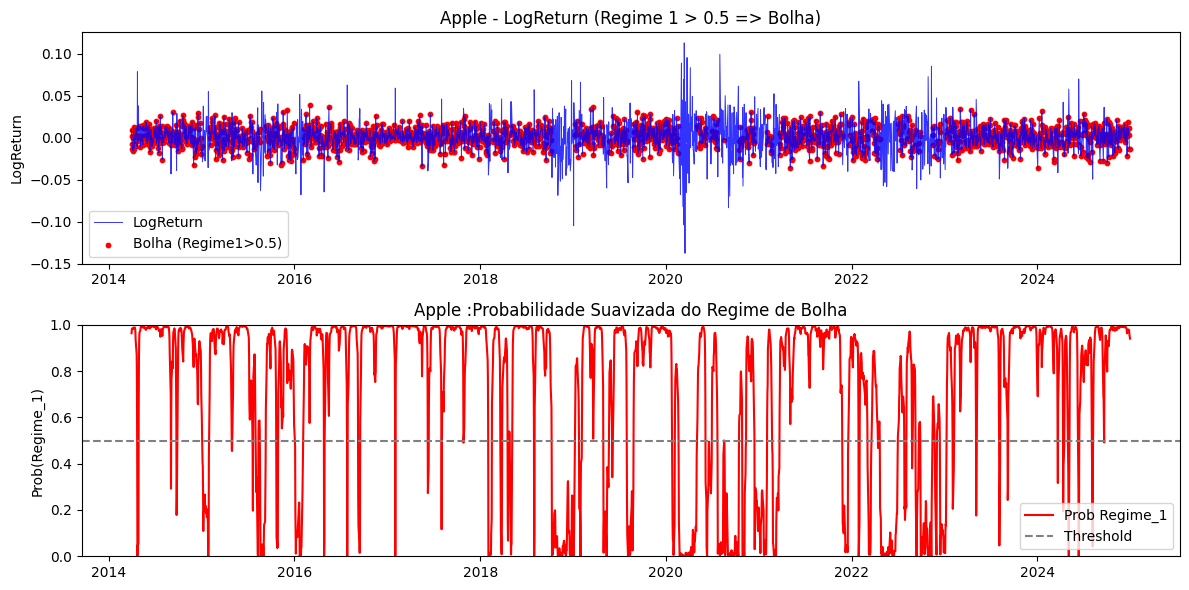


=== Ajustando MarkovSwitching para Microsoft ===
Microsoft - all_merged subset: primeiro date = 2014-03-31 00:00:00, último date = 2024-12-31 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Microsoft - final_df pós Markov: primeiro date = 2014-04-01 00:00:00, último date = 2024-12-31 00:00:00


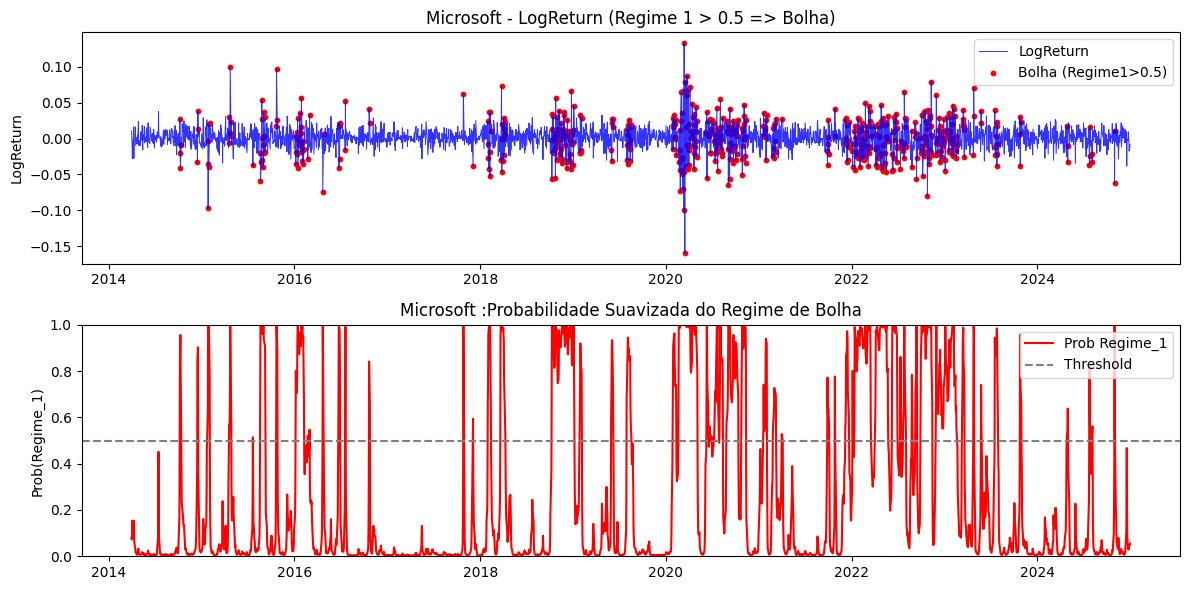


=== Ajustando MarkovSwitching para Amazon ===
Amazon - all_merged subset: primeiro date = 2013-04-01 00:00:00, último date = 2024-12-31 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Amazon - final_df pós Markov: primeiro date = 2013-04-02 00:00:00, último date = 2024-12-31 00:00:00


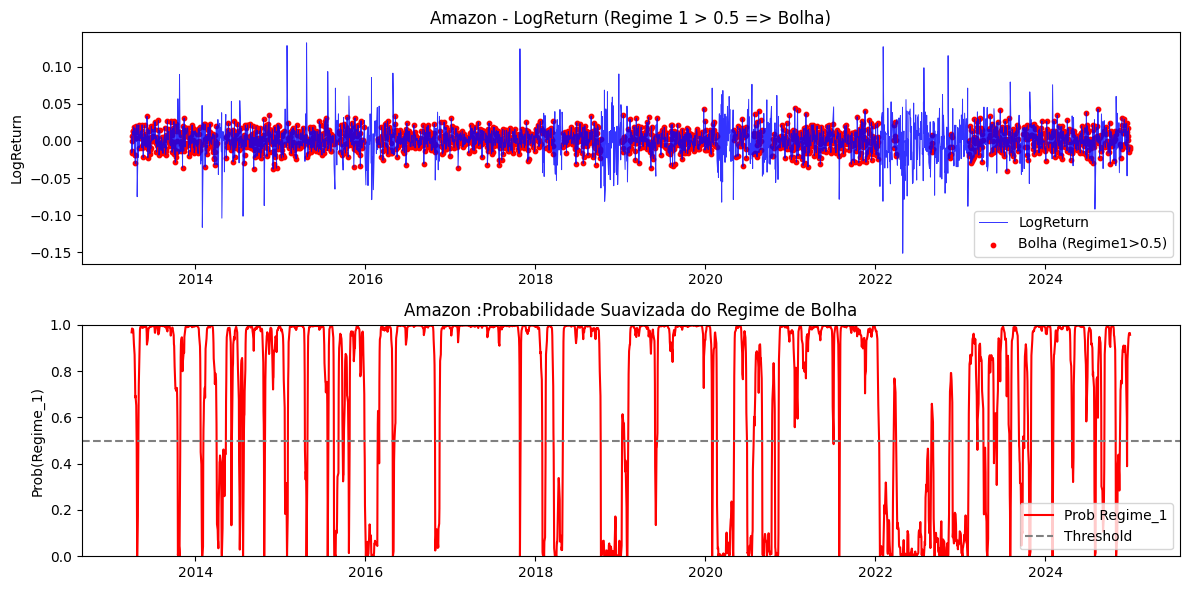


=== Ajustando MarkovSwitching para Meta ===
Meta - all_merged subset: primeiro date = 2013-04-01 00:00:00, último date = 2024-12-31 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Meta - final_df pós Markov: primeiro date = 2013-04-02 00:00:00, último date = 2024-12-31 00:00:00


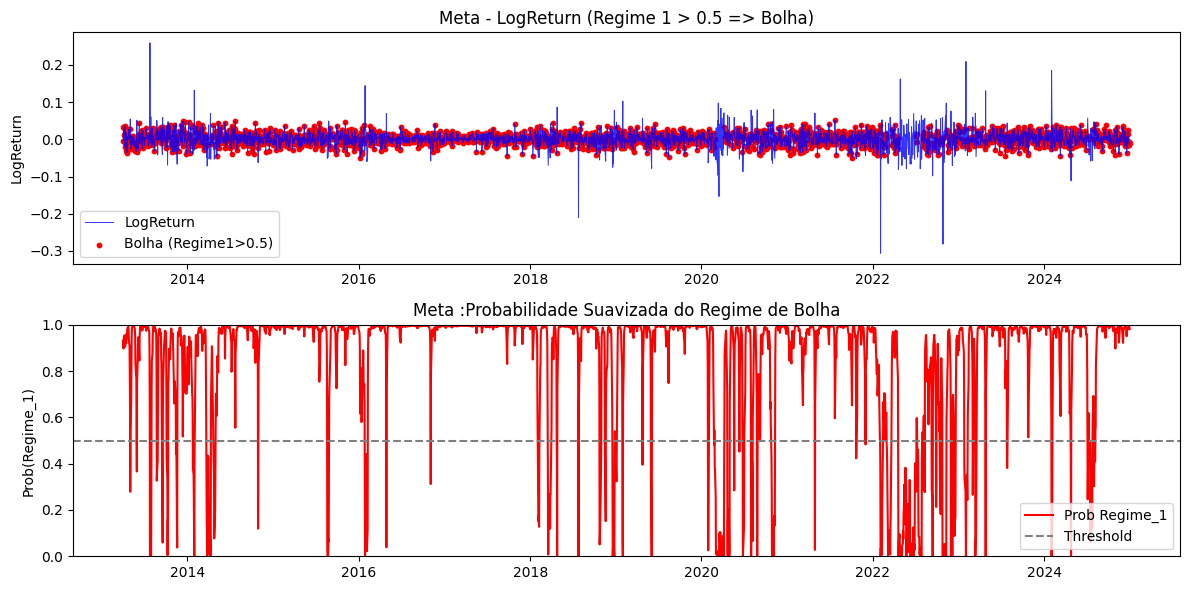


=== Ajustando MarkovSwitching para Google ===
Google - all_merged subset: primeiro date = 2013-04-01 00:00:00, último date = 2024-12-31 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Google - final_df pós Markov: primeiro date = 2013-04-02 00:00:00, último date = 2024-12-31 00:00:00


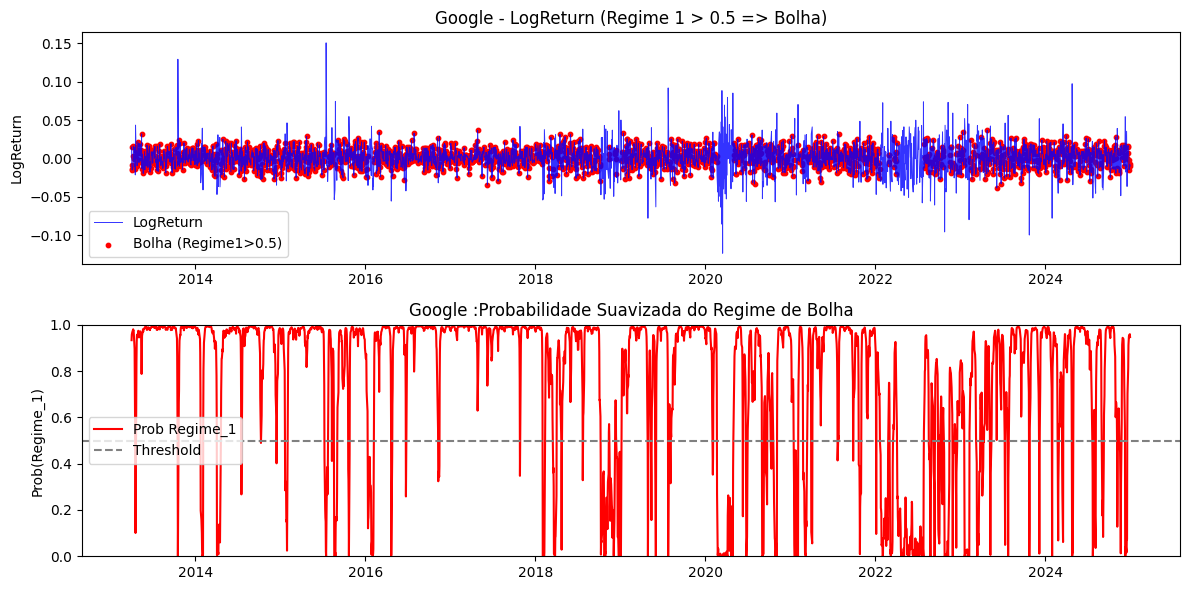


=== Ajustando MarkovSwitching para Nvidia ===
Nvidia - all_merged subset: primeiro date = 2013-04-29 00:00:00, último date = 2025-01-27 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Nvidia - final_df pós Markov: primeiro date = 2013-04-30 00:00:00, último date = 2025-01-27 00:00:00


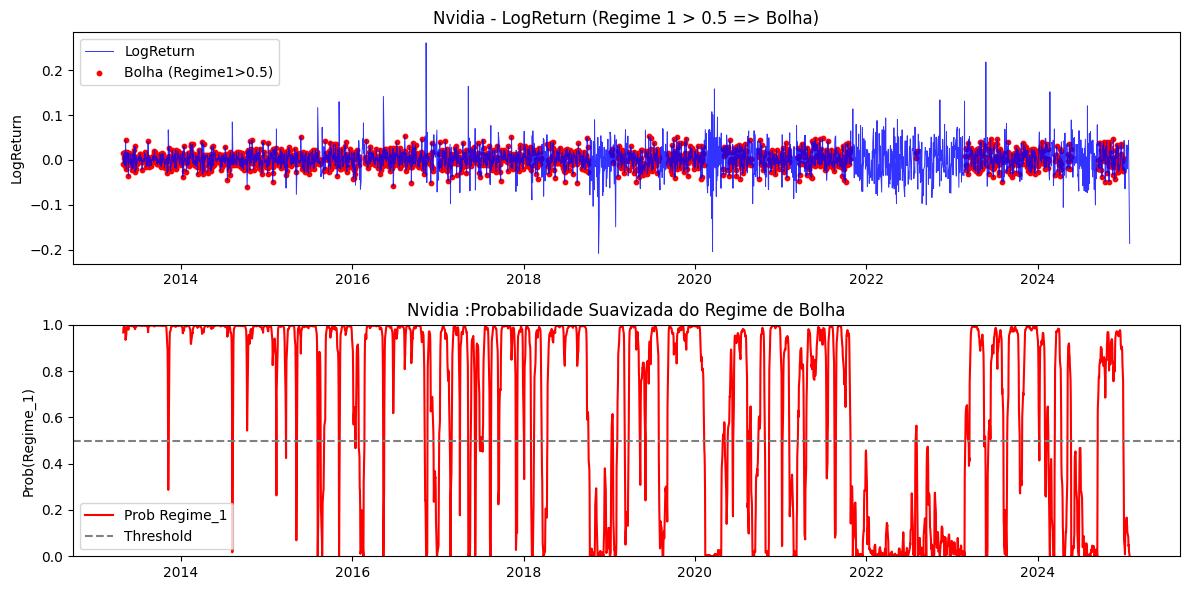


=== Ajustando MarkovSwitching para Tesla ===
Tesla - all_merged subset: primeiro date = 2013-03-01 00:00:00, último date = 2024-12-02 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Tesla - final_df pós Markov: primeiro date = 2013-03-04 00:00:00, último date = 2024-12-02 00:00:00


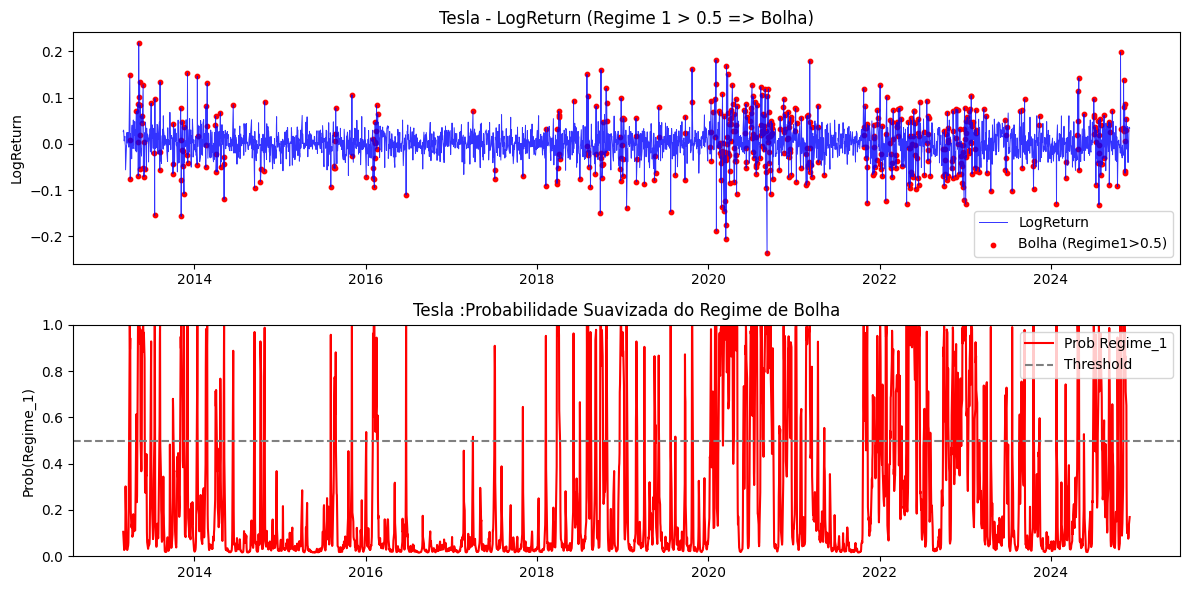

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

def markov_switching_bubble_analysis(
    all_merged,
    companies=["Apple", "Microsoft", "Amazon", "Meta", "Google", "Nvidia", "Tesla"],
    price_col='Close',
    k_regimes=2,
    switching_variance=True,
    bubble_regime=1,
    bubble_threshold=0.5
):
    """
    Fluxo completo:
      1) Ajusta MarkovRegression (log-retornos) para cada empresa.
      2) Cria DataFrame final com colunas: Date, LogReturn, Regime_0, Regime_1, etc.
      3) Marca 'BubbleLabel' se a probabilidade do regime bubble_regime for maior que bubble_threshold.
      4) Plota dois subplots por empresa:
           - Subplot 1: log-retorno (destacando os pontos em bolha com outra cor).
           - Subplot 2: probabilidade do regime bubble_regime.

    Retorna um dicionário:
      results[comp]["aligned_df"] => DataFrame final com coluna Date,
      results[comp]["model"] => objeto MarkovRegression,
      results[comp]["result"] => objeto MarkovRegressionResults.
    """
    results = {}

    # Itera sobre cada empresa
    for comp in companies:
        print(f"\n=== Ajustando MarkovSwitching para {comp} ===")
        df_temp = all_merged[all_merged['Company'] == comp].copy()
        df_temp.sort_values('Date', inplace=True)

        # Debug: datas do subset original (all_merged para a empresa)
        subset_first_date = pd.to_datetime(df_temp['Date']).min()
        subset_last_date = pd.to_datetime(df_temp['Date']).max()
        print(f"{comp} - all_merged subset: primeiro date = {subset_first_date}, último date = {subset_last_date}")

        # Converte a coluna Date para datetime, se necessário e seta como índice
        if not np.issubdtype(df_temp['Date'].dtype, np.datetime64):
            df_temp['Date'] = pd.to_datetime(df_temp['Date'], errors='coerce')
        df_temp = df_temp.set_index('Date')

        # Remove linhas sem preço
        df_temp = df_temp.dropna(subset=[price_col])
        if df_temp.empty:
            print(f"{comp}: DataFrame vazio após remover NaN em {price_col}.")
            results[comp] = None
            continue

        # Calcula log-retornos (o índice agora é a data correta)
        series_price = df_temp[price_col]
        logreturns = np.log(series_price).diff().dropna()

        if len(logreturns) < 30:
            print(f"{comp}: poucas observações de log-retorno (<30). Skipping.")
            results[comp] = None
            continue

        # Ajusta o modelo Markov Switching sobre os log-retornos
        mod = MarkovRegression(
            endog=logreturns,
            k_regimes=k_regimes,
            trend='n',  # sem intercepto
            switching_variance=switching_variance
        )
        try:
            res = mod.fit(em_iter=50, search_reps=10)
        except Exception as e:
            print(f"Erro ao ajustar {comp}: {e}")
            results[comp] = None
            continue

        # Extrai as probabilidades suavizadas dos regimes
        smoothed_probs = res.smoothed_marginal_probabilities
        if isinstance(smoothed_probs, (pd.DataFrame, pd.Series)):
            smoothed_probs = smoothed_probs.values

        # Cria o DataFrame final a partir dos log-retornos,
        # fazendo reset_index para transformar o índice (data) em coluna.
        final_df = logreturns.to_frame(name='LogReturn').reset_index()

        # Alinha o tamanho do DataFrame com o vetor de probabilidades
        common_n = min(len(final_df), smoothed_probs.shape[0])
        final_df = final_df.iloc[-common_n:].copy()
        regimes = smoothed_probs[-common_n:, :]
        for r in range(k_regimes):
            final_df[f"Regime_{r}"] = regimes[:, r]

        # Debug: datas do DataFrame final (pós Markov)
        final_first_date = final_df['Date'].min()
        final_last_date = final_df['Date'].max()
        print(f"{comp} - final_df pós Markov: primeiro date = {final_first_date}, último date = {final_last_date}")

        # Marca os pontos de bolha
        bubble_col = f"Regime_{bubble_regime}"
        if bubble_col in final_df.columns:
            final_df['BubbleLabel'] = final_df[bubble_col] > bubble_threshold
        else:
            final_df['BubbleLabel'] = False

        results[comp] = {
            'model': mod,
            'result': res,
            'aligned_df': final_df
        }

        # ================= Geração dos Plots =================
        plt.figure(figsize=(12, 6))

        # Subplot 1: Log-retorno com destaque para os pontos de bolha
        ax1 = plt.subplot(2, 1, 1)
        ax1.set_title(f"{comp} - LogReturn (Regime {bubble_regime} > {bubble_threshold} => Bolha)")
        ax1.set_ylabel("LogReturn")
        ax1.plot(final_df['Date'], final_df['LogReturn'], color='blue', linewidth=0.7, alpha=0.8, label="LogReturn")

        # Destaca os pontos onde BubbleLabel é True
        bubble_mask = final_df['BubbleLabel'] == True
        ax1.scatter(final_df.loc[bubble_mask, 'Date'], final_df.loc[bubble_mask, 'LogReturn'],
                    color='red', s=10, label="Bolha (Regime1>0.5)")
        ax1.legend(loc='best')
        ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

        # Subplot 2: Probabilidade do regime de bolha
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
        ax2.set_ylabel(f"Prob(Regime_{bubble_regime})")
        ax2.set_ylim(0, 1)
        ax2.plot(final_df['Date'], final_df[bubble_col], color='red', label=f"Prob Regime_{bubble_regime}")
        ax2.axhline(bubble_threshold, color='gray', linestyle='--', label="Threshold")
        ax2.set_title(f"{comp} :Probabilidade Suavizada do Regime de Bolha")
        ax2.legend(loc='best')
        ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

        plt.tight_layout()
        plt.show()

    return results
resultados = markov_switching_bubble_analysis(all_merged)
